# Prediction of bankruptcy for Polish companies based on financial data

This case study aims to predict "bankruptcy" (or, in other words, the financial situation of a company) based on financial data (financial ratios).

In [1]:
# Install the libraries if necessary
!pip install pdf2image

In [2]:
# Import the necessary libraries
from google.colab import files
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pdf2image import convert_from_path
from IPython.display import display
from scipy.stats import linregress
from scipy import stats
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Variables selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
# Split data
from sklearn.model_selection import train_test_split
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
# Sampling
from imblearn.over_sampling import SMOTE
# Models saving
import pickle
# Evaluation
from sklearn.metrics import roc_curve, auc

<a id="section-1"></a>
## 1. Data understanding


### 1.1. Import Data

In [ ]:
# Import data ".zip"
file = files.upload()

Saving polish+companies+bankruptcy+data.zip to polish+companies+bankruptcy+data.zip


In [ ]:
! unzip polish+companies+bankruptcy+data.zip

Archive:  polish+companies+bankruptcy+data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


In [ ]:
# Data rangling
year1 = arff.loadarff('1year.arff')
year2 = arff.loadarff('2year.arff')
year3 = arff.loadarff('3year.arff')
year4 = arff.loadarff('4year.arff')
year5 = arff.loadarff('5year.arff')

Y1 = pd.DataFrame(year1[0])
Y2 = pd.DataFrame(year2[0])
Y3 = pd.DataFrame(year3[0])
Y4 = pd.DataFrame(year4[0])
Y5 = pd.DataFrame(year5[0])

df_concat = pd.concat([Y1, Y2, Y3, Y4, Y5], axis=0)
df_concat.head()

Attr1    Attr2    Attr3   Attr4    Attr5    Attr6     Attr7    Attr8  \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  0.43695   
3  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704  1.86610   
4  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320  0.63070   

    Attr9   Attr10  ...    Attr56   Attr57   Attr58    Attr59  Attr60  Attr61  \
0  1.1389  0.50494  ...  0.121960  0.39718  0.87804  0.001924  8.4160  5.1372   
1  1.6996  0.49788  ...  0.121300  0.42002  0.85300  0.000000  4.1486  3.2732   
2  1.3090  0.30408  ...  0.241140  0.81774  0.76599  0.694840  4.9909  3.9510   
3  1.0571  0.57353  ...  0.054015  0.14207  0.94598  0.000000  4.5746  3.6147   
4  1.1559  0.38677  ...  0.134850  0.48431  0.86515  0.124440  6.3985  4.3158   

    Attr62  Attr63   Attr64  class  
0   82.658  4.4158   7.4277   b'0'  
1  107.350  3.4000  60.9870   b'0'  
2  134.270  2.7185   5.2078   b'0'  
3   86.435  4.2228   5.5497   b'0'  
4  127.210  2.8692   7.8980   b'0'  

[5 rows x 65 columns]

### 1.2. Adopted strategy

To ensure the proper functioning of our model, we will divide the data into two groups:

* Data for modeling: 1year, 2year, 3year, 4year

* Data for backtesting: 5year

In [ ]:
# Modeling data
df_concat = pd.concat([Y1, Y2, Y3, Y4], axis=0)

# Backtesting data
df_backtesting = Y5

In [ ]:
# Save data in excel format
#df_concat.to_excel("output.xlsx", sheet_name='Sheet_name_1')

### 1.3. Clarify the variables

To understand the data, I revisited the provided description and transformed them into common ratios. I used "Excel" for this step, so it's a manual process that cannot be automated as it requires human intervention.

In [ ]:
# Import data tranformed
file = files.upload()

Saving var_des.xlsx to var_des.xlsx


In [ ]:
description = pd.read_excel(r'var_des.xlsx', sheet_name='description_')
# Extract "ratio"  column
column_list = description['ratio'].tolist()
print(column_list)

['ROA', 'Debt-to-assets ', 'Working capital', 'current ratio', 'Attr5', 'ROE', 'ROA1', 'Equity-to-liability', 'Asset turnover', 'Equity-to-assets', 'Attr11', 'Gross profit ', 'Gross profit margin ', 'Attr14', 'Attr15', 'Coverage', 'Leverage', 'Gross profit margin or ROA', 'Gross profit margin1', 'Inventory turnover', 'Sales growth rate', 'ROA2', 'Net profit margin', 'Attr24', 'Attr25', 'Attr26', 'Operating return on assets', 'Attr28', 'Attr29', 'Attr30', 'Gross Profit', 'days payable outstanding', 'Attr33', 'Attr34', 'ROA3', 'Assets turnover', 'acid-test ratio', 'Attr38', 'Net profit margin1', 'Attr40', 'Attr41', 'operating profit margin', 'Attr43', 'Days sales outstanding', 'Attr45', 'Quick Ratio', 'inventory turnover in days', 'ROTA', 'Net profit margin2', 'Attr50', 'Total debt to assets', 'short-term liabilities turnover in days', 'Attr53', 'Attr54', 'working capital', 'Gross profit margin2', 'working capital turnover', 'cost-to-sales', 'Attr59', 'inventory turnover', 'accounts rece

In [ ]:
# Rename columns
df_concat.rename(columns=dict(zip(df_concat.columns, column_list)), inplace=True)

# Remplace "'" and "b" on target modality
df_concat['target'] = df_concat['target'].str.decode('utf-8').str.replace(r"[\'b]", '', regex=True)

In [ ]:
# Get the data types of variables in the DataFrame
variable_types = df_concat.dtypes
print(variable_types)

ROA                                 float64
Debt-to-assets                      float64
Working capital                     float64
current ratio                       float64
Attr5                               float64
                                     ...   
accounts receivable turnover        float64
short-term liabilities turnover     float64
short-term liabilities turnover1    float64
fixed assets turnover               float64
target                               object
Length: 65, dtype: object


In [ ]:
# Descriptive statistics
stat = df_concat.describe().transpose()

# Add other statistics
stat['median'] = df_concat.median()
stat['std_dev'] = df_concat.std()
stat['moyenne'] = df_concat.mean()
# Display the statistical table
print(stat)

                                    count         mean            std  \
ROA                               37490.0     0.044220       2.095612   
Debt-to-assets                    37490.0     0.609927       5.856861   
Working capital                   37490.0     0.102657       5.833509   
current ratio                     37382.0     6.538754     315.776182   
Attr5                             37417.0  -449.158240   65337.198678   
...                                   ...          ...            ...   
inventory turnover                35611.0   374.739041   23663.747416   
accounts receivable turnover      37408.0    17.993174     594.803462   
short-term liabilities turnover   37368.0  1701.660589  149854.488569   
short-term liabilities turnover1  37382.0     9.376997     127.184141   
fixed assets turnover             36790.0    73.973463    2402.042281   

                                           min        25%        50%  \
ROA                              -2.568900e+02   0.

<ipython-input-17-976f2cd18c99>:6: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  stat['std_dev'] = df_concat.std()


### 1.4. Literature review

We propose a graph summarizing the main financial ratios (the LaTeX script is attached).

In [3]:
# Import a PDF file summarizing the main financial ratios
file = files.upload()

Saving ratio_fin.pdf to ratio_fin.pdf


In [4]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (504 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


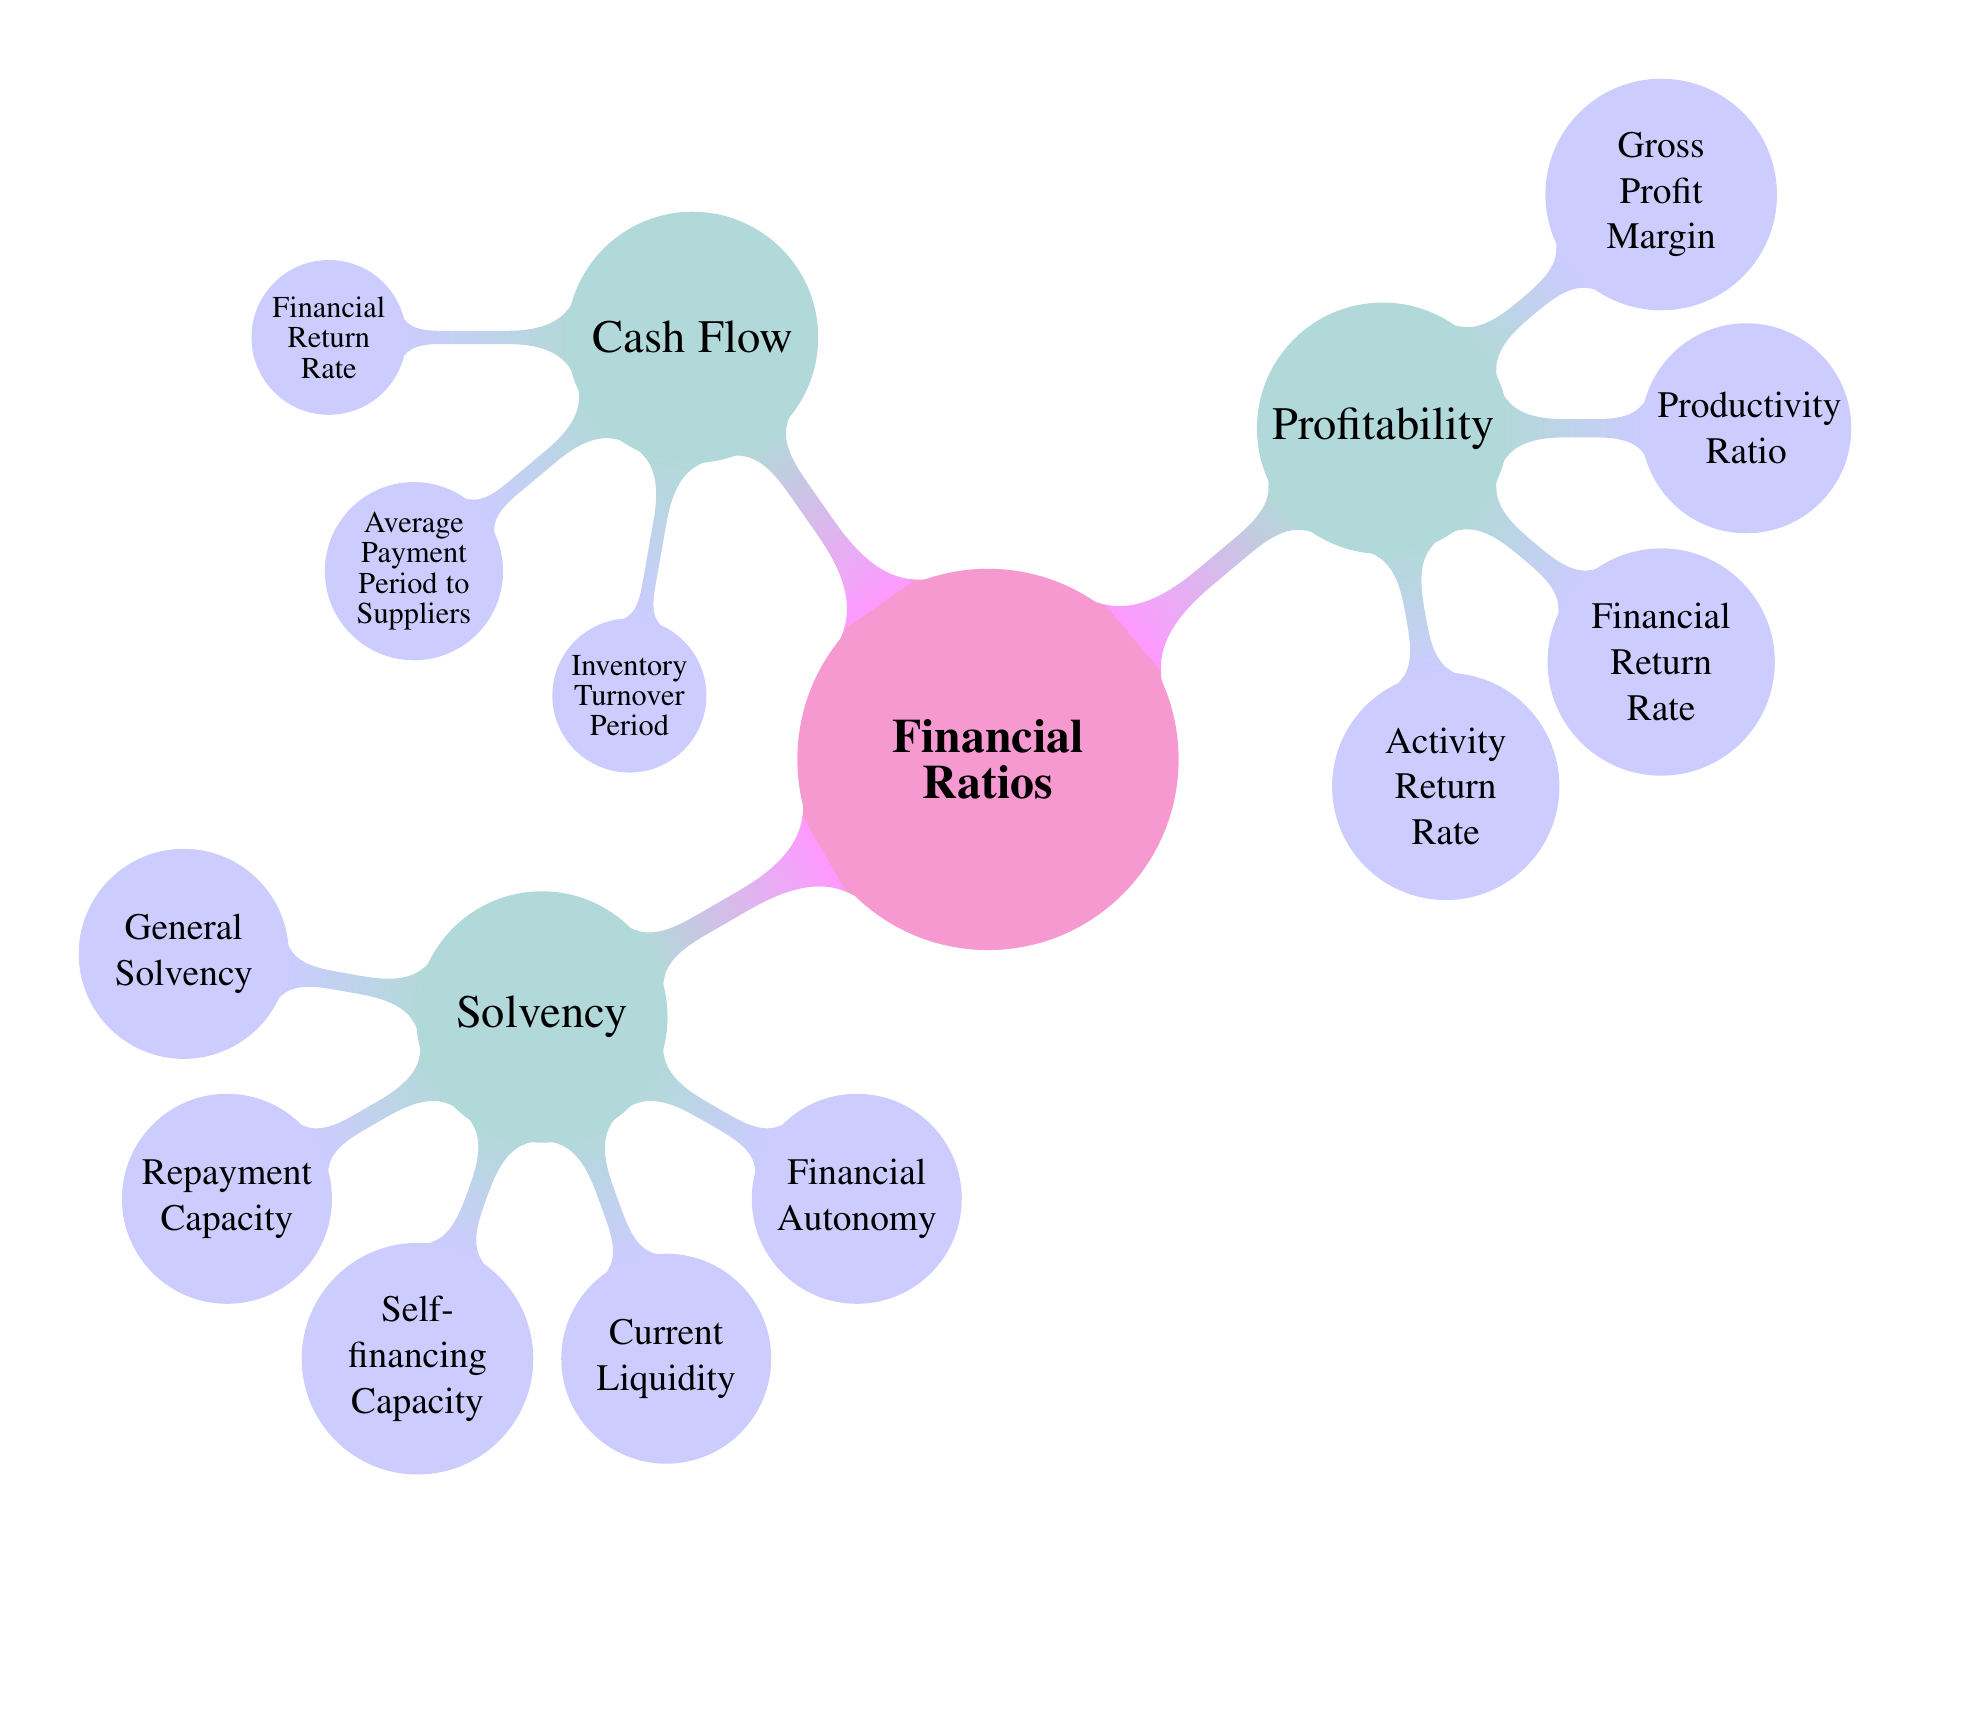

In [5]:
# Specify the file path of the PDF
pdf_file_path = '/content/ratio_fin.pdf'
# Convert the PDF pages to images
images = convert_from_path(pdf_file_path)
# Display each image
for image in images:
    display(image)

This graph outlines the key ratios. In the current database, it includes some financial ratios. (The present database utilizes fractions between balance sheet items, so sometimes a financial explanation may not be readily apparent).

In the following section (data visualization), we will interpret only the financial ratios.


## 2. Data Visualization

Data visualization will be broken down into three types of analysis:

    1- Univariate,
    2- Bivariate, and
    3- Multivariate.

i.e. Our database is of cross-sectional type (individual data), it contains continuous quantitative variables (except for the "class," which is a nominal qualitative variable). Hence, the appropriate graphical representation will be in the form of: a Histogram, a Probability Density, a Boxplot, or a Scatterplot.

### 2.1. Univariate

Univariate analysis involves studying and analyzing only one variable (uni) at a time. It helps to understand the distribution, trends, and characteristics of a given variable.

#### a- Boxplot

The boxplot (or box-and-whisker plot) is a graphical representation that allows visualizing the distribution of a set of numerical data. It provides information about the median, quartiles, data dispersion, and the presence of outliers.

In [ ]:
# Le box-plot for all variables
for col in column_list[1:64]:
    plt.boxplot(x = df_concat[1:64][col],
                whis = 3,# set extreme ourlier x > Q3+3(Q3-Q1) & X < Q1-3(Q3-Q1)
                patch_artist=True,
                showmeans=True, # mean: show with point
                boxprops = {'color':'black','facecolor':'#9999ff'}, #set box features
                flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}, # outlier: show with o
                meanprops = {'marker':'D','markerfacecolor':'indianred'},
                medianprops = {'linestyle':'--', 'linewidth':2.5, 'color':'orange'}) # medium: show with line
    plt.tick_params(top='off', right='off')
    plt.xlabel(""+ col)  # Set an empty x-axis label
    plt.title("BoxPlot on: " + col )
    plt.show()

D'après les graphiques ci-dessus, on observe certaines box-plot illisibles d'observer l'étendue interquartile (IQR) cela revient à l'existence des valeurs aberrantes.

Afin, de palier cet incovénient on va ajuster les graphiques en éliminant les valeurs aberrantes.

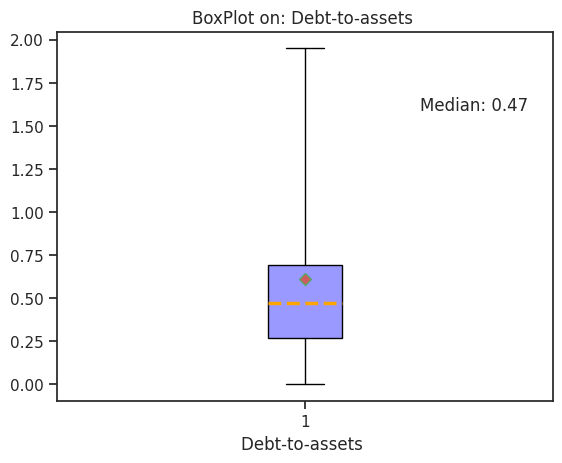

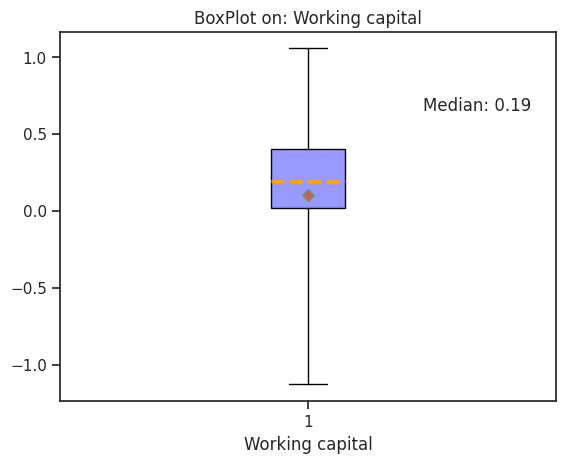

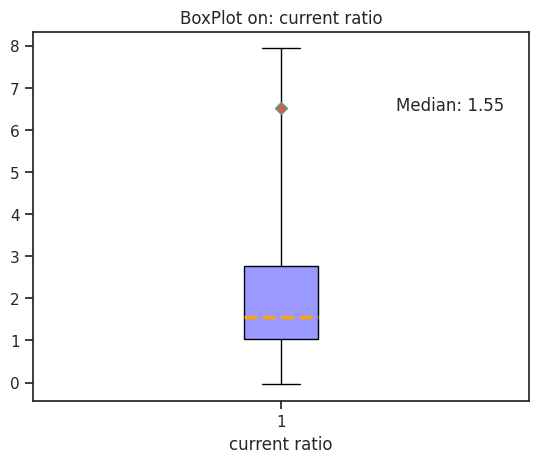

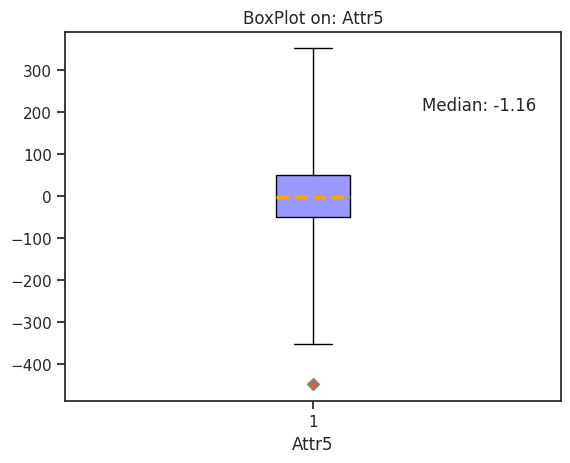

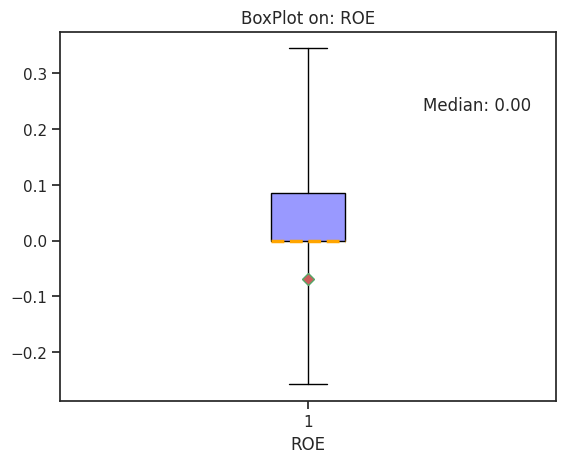

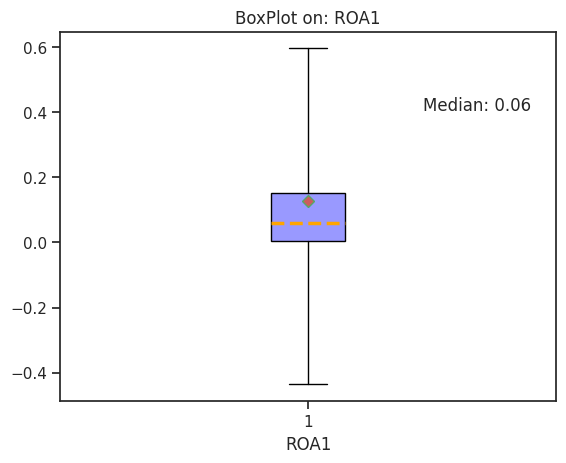

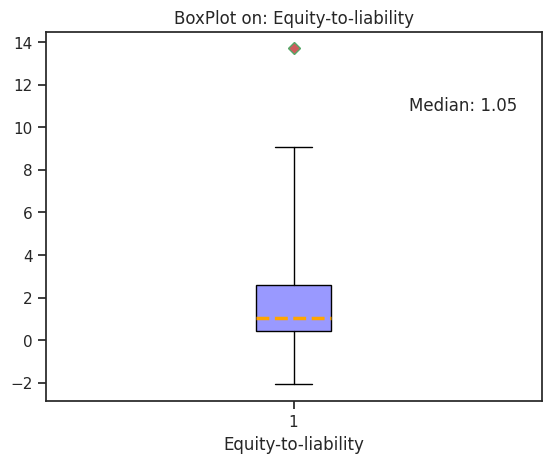

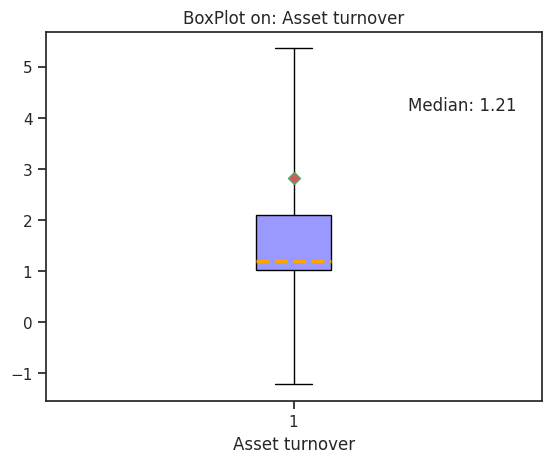

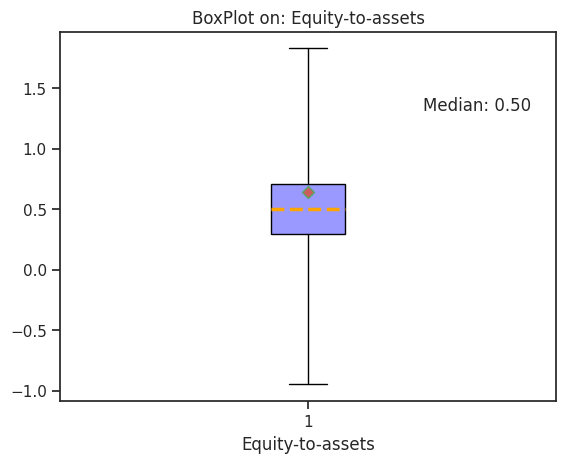

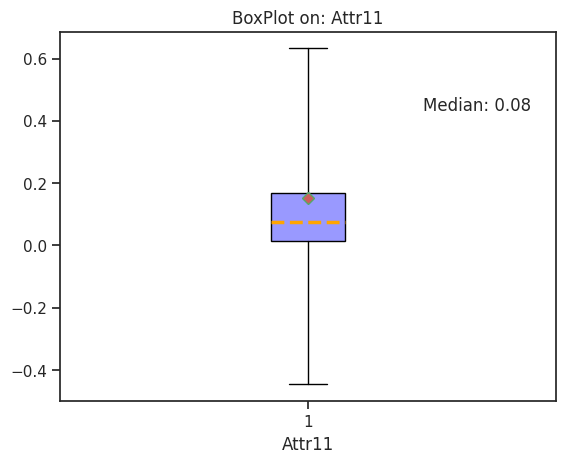

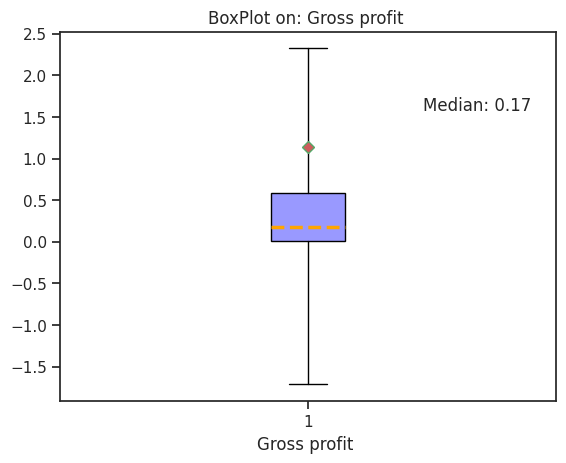

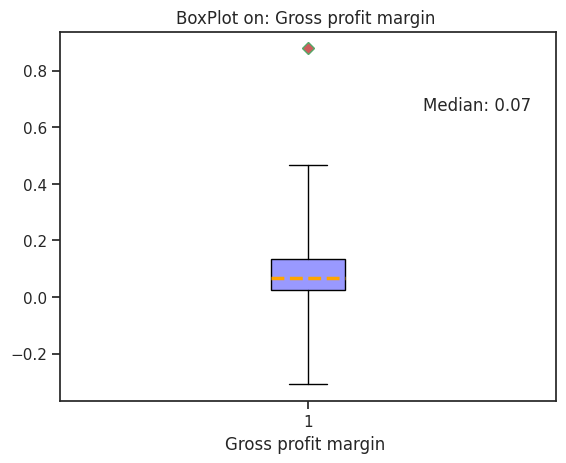

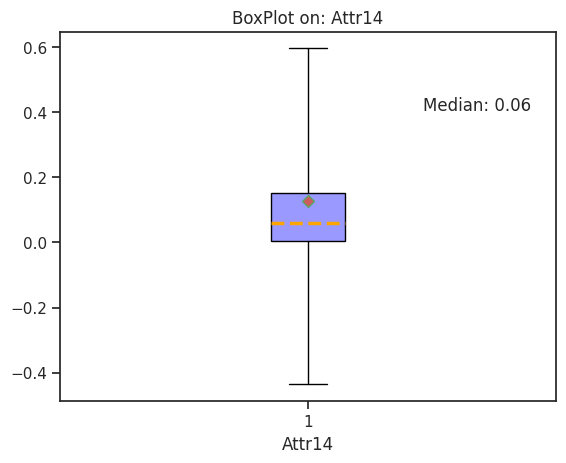

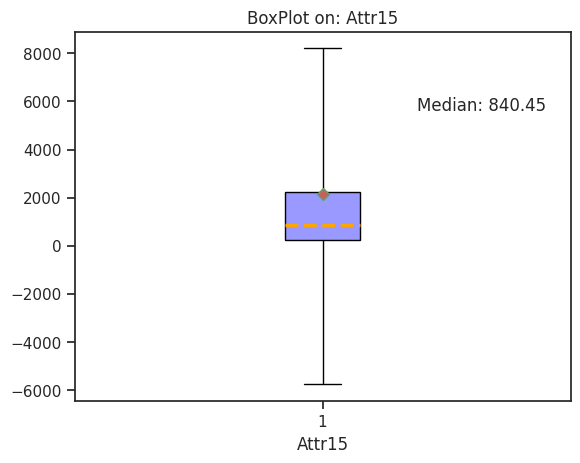

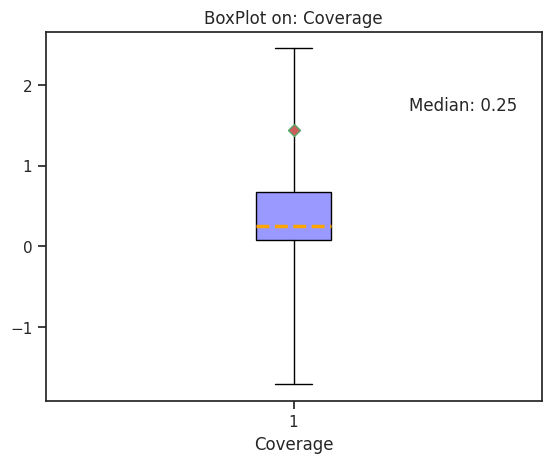

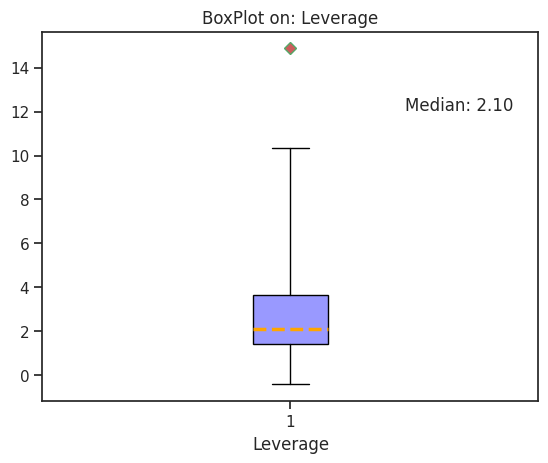

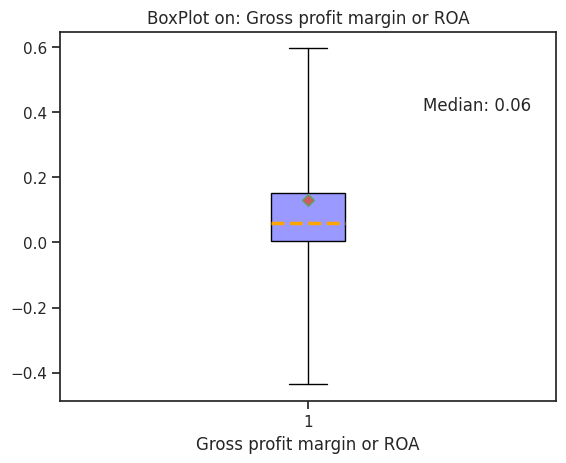

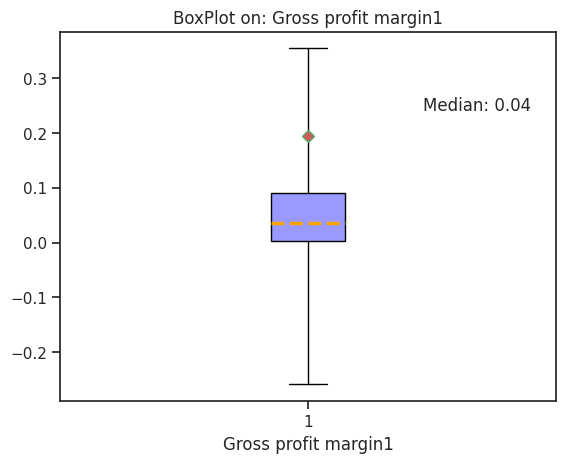

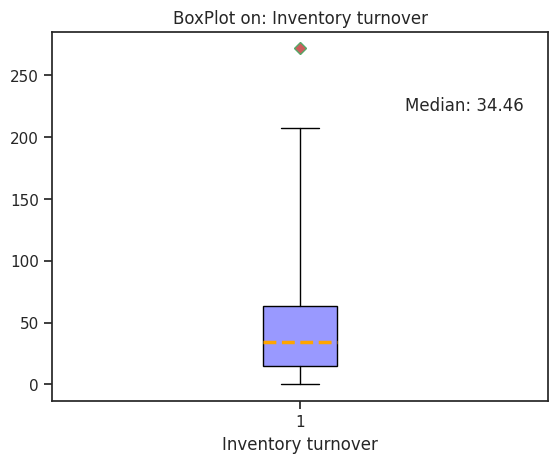

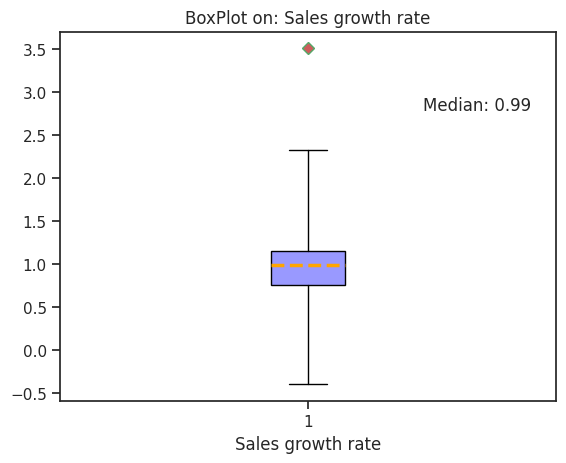

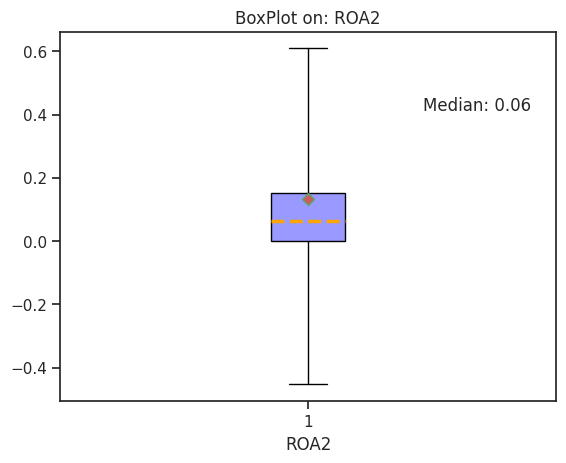

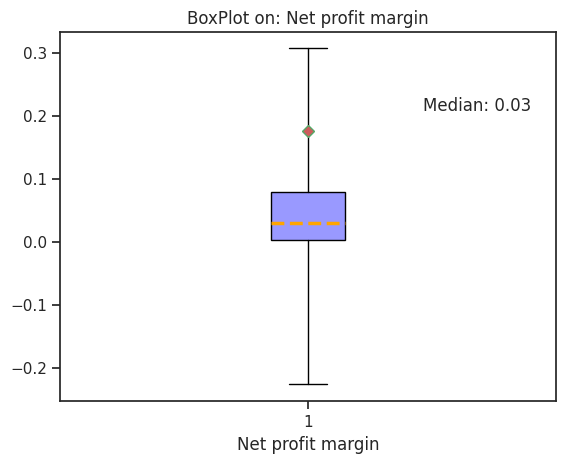

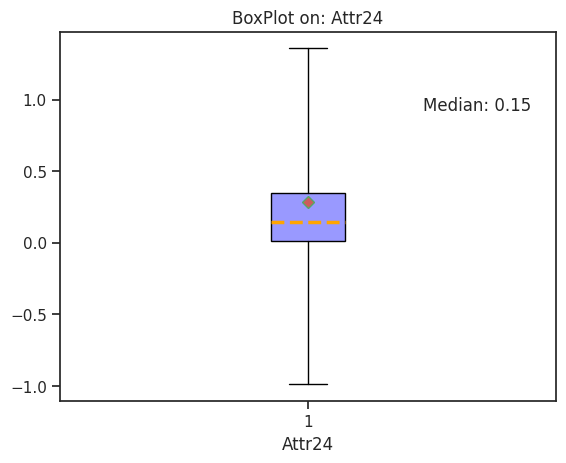

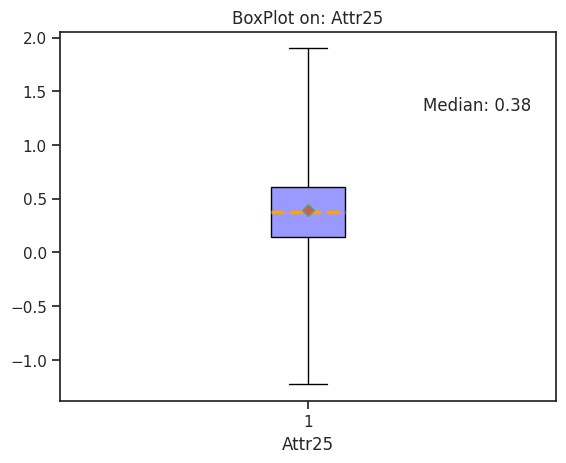

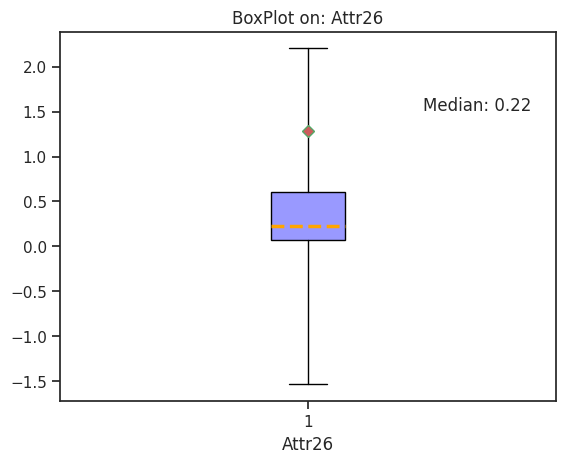

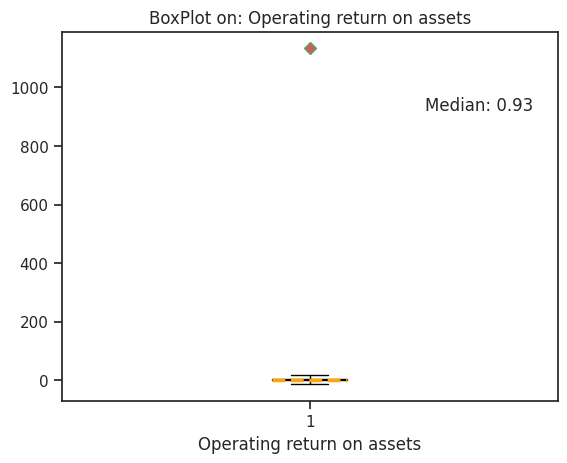

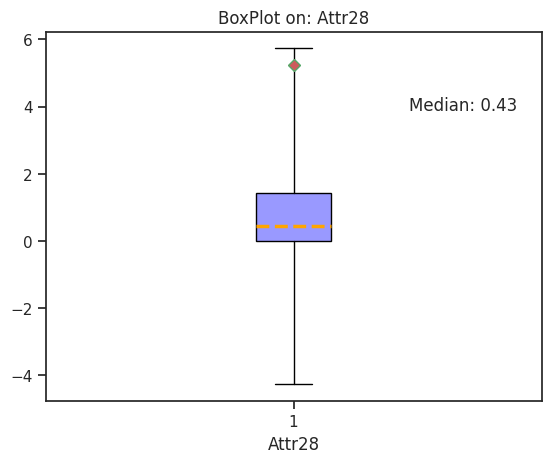

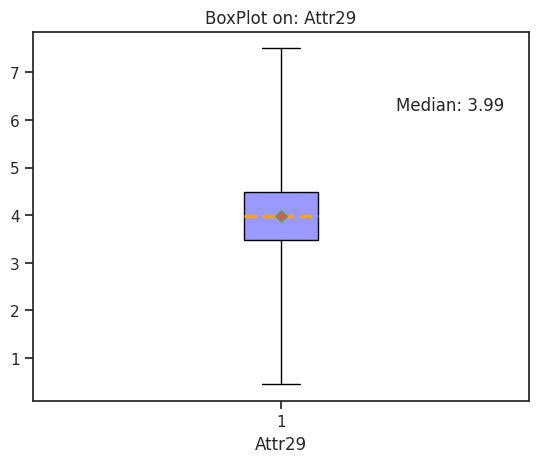

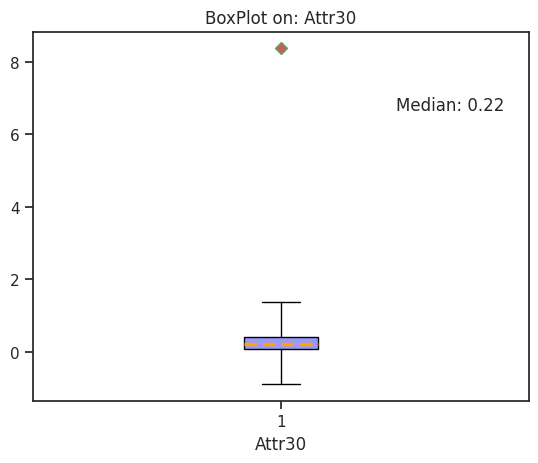

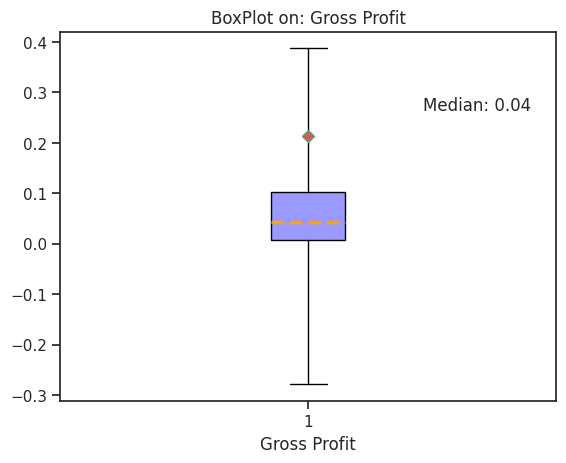

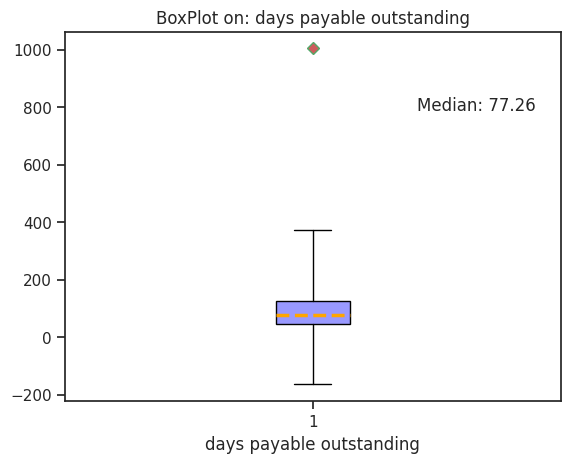

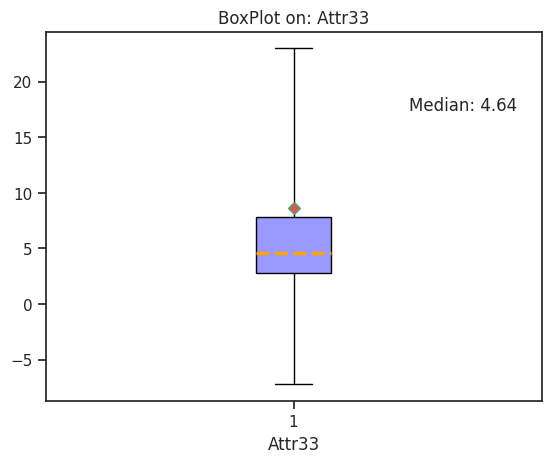

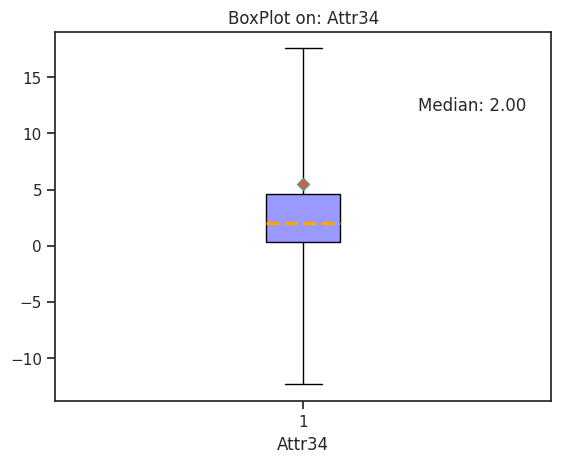

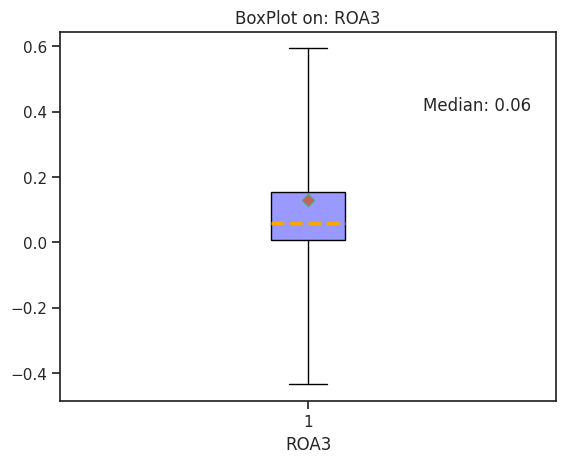

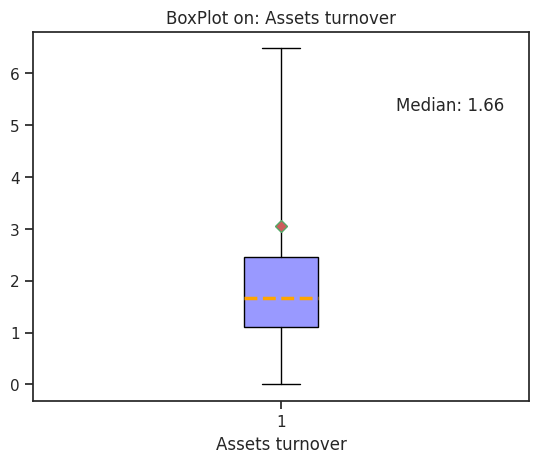

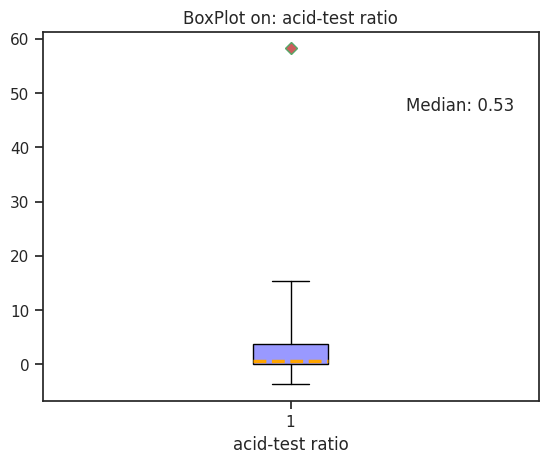

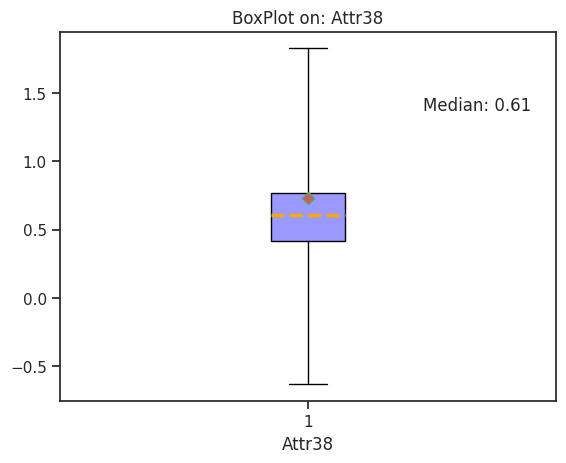

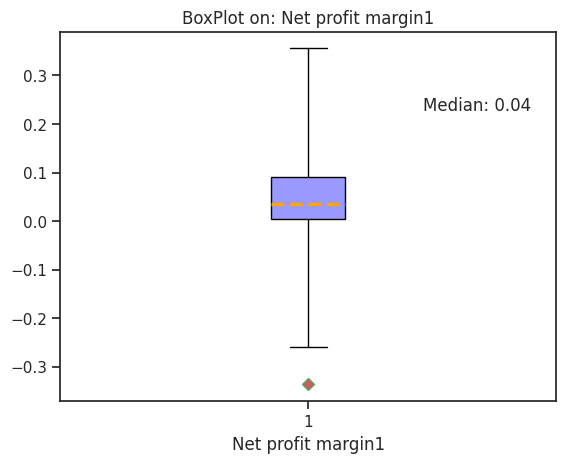

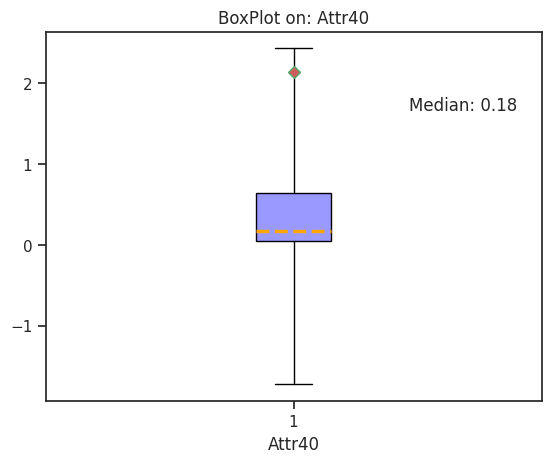

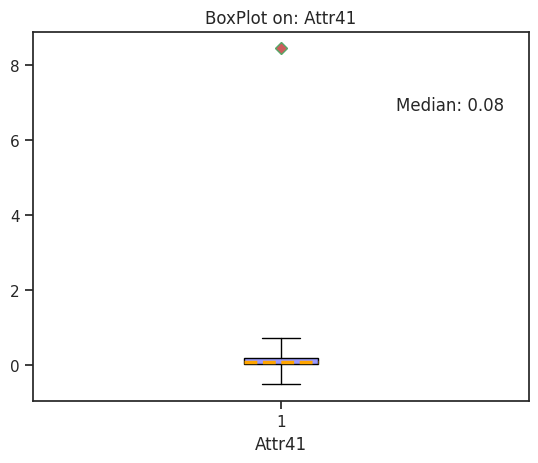

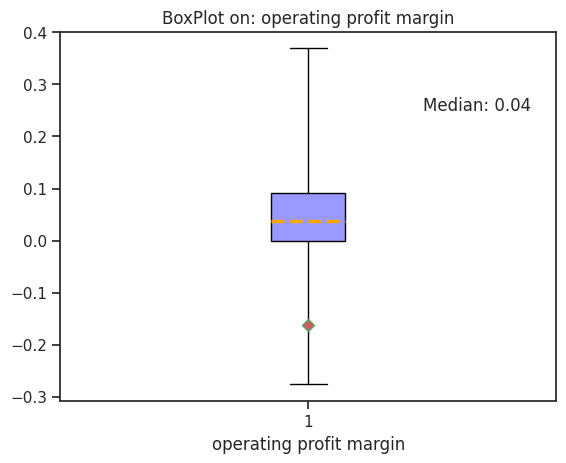

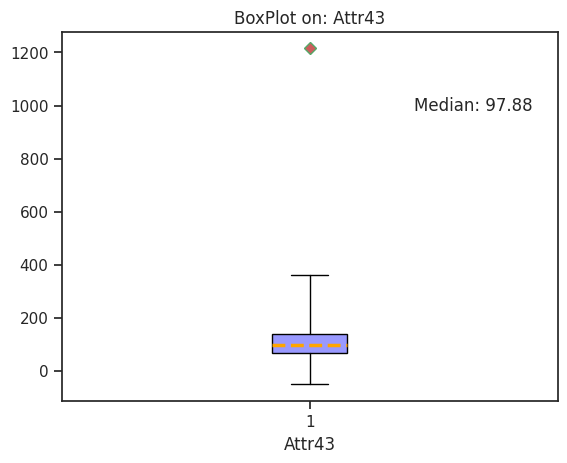

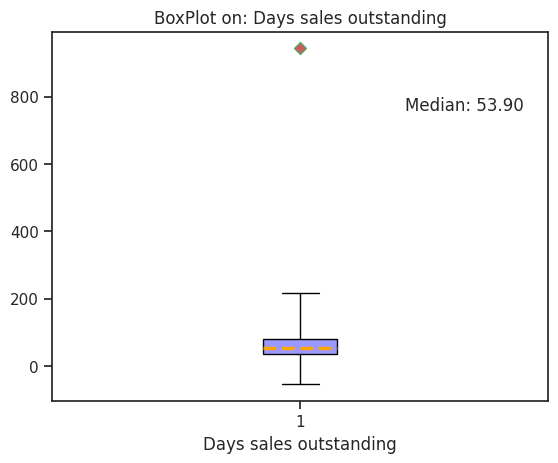

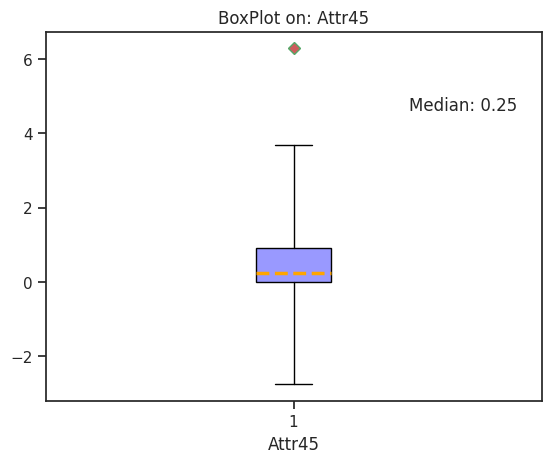

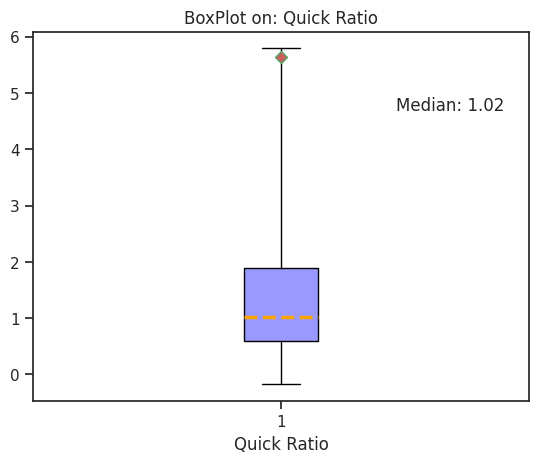

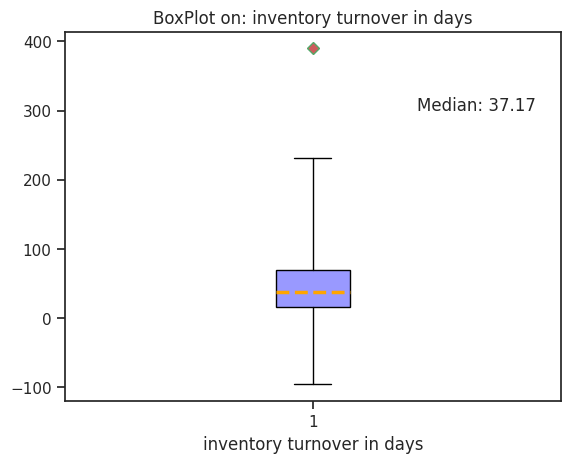

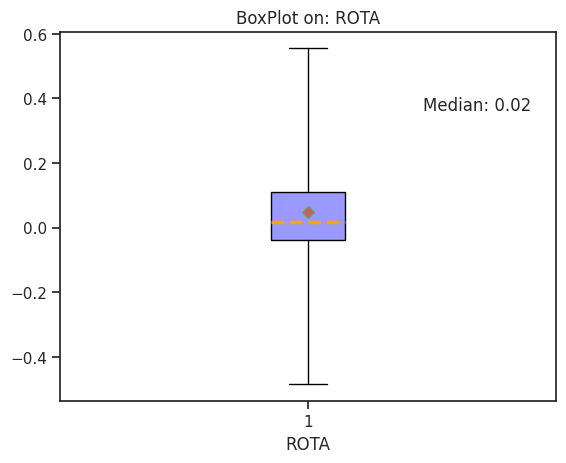

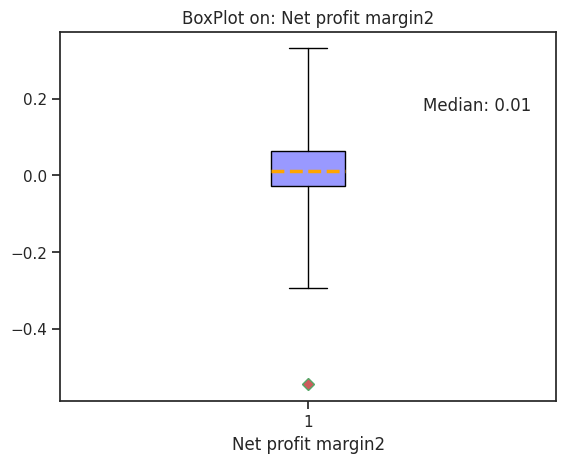

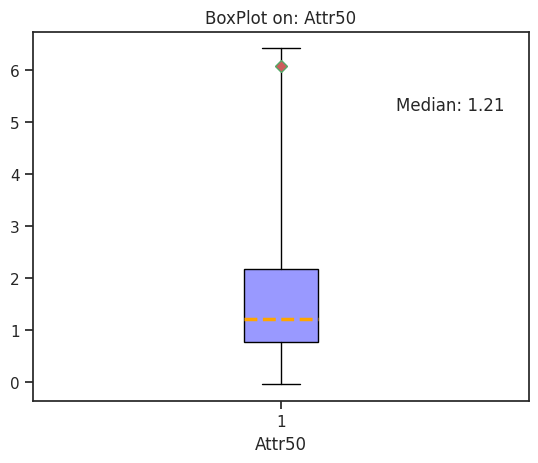

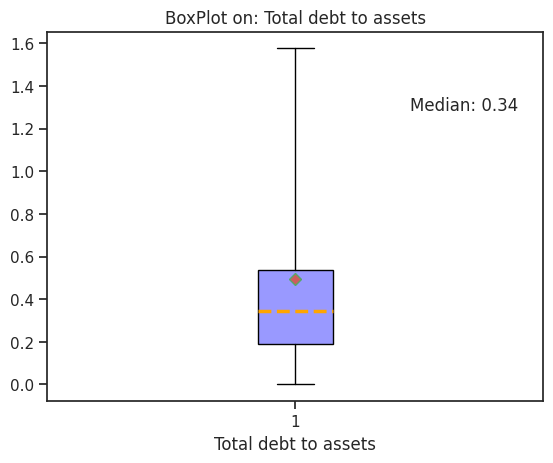

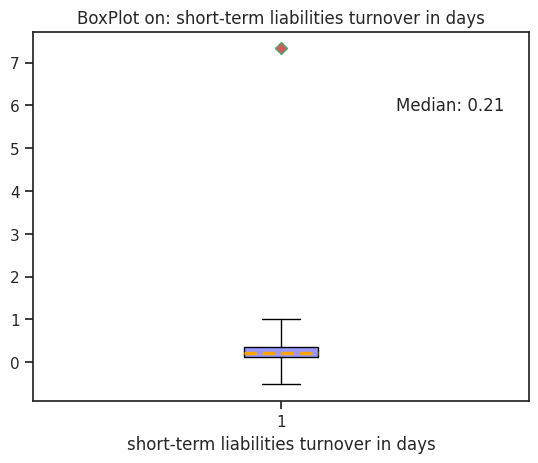

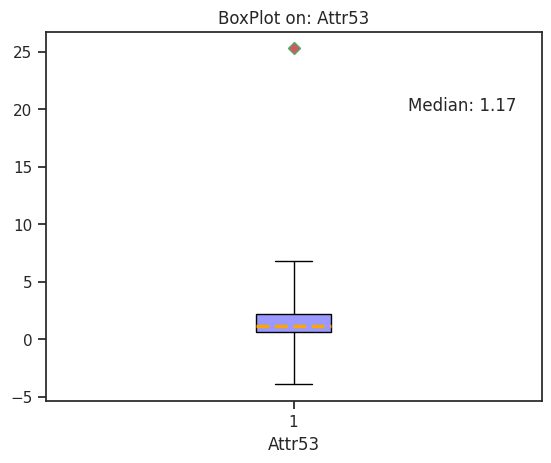

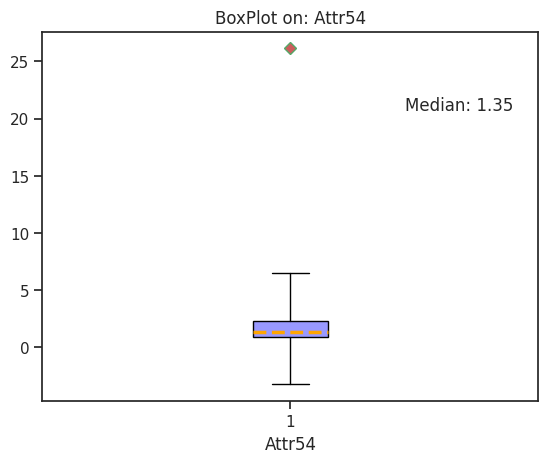

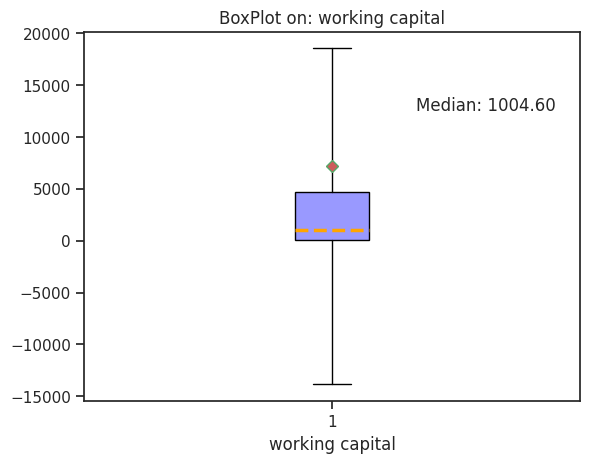

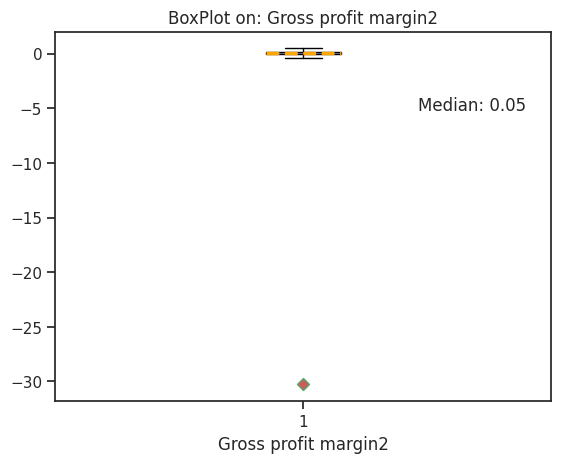

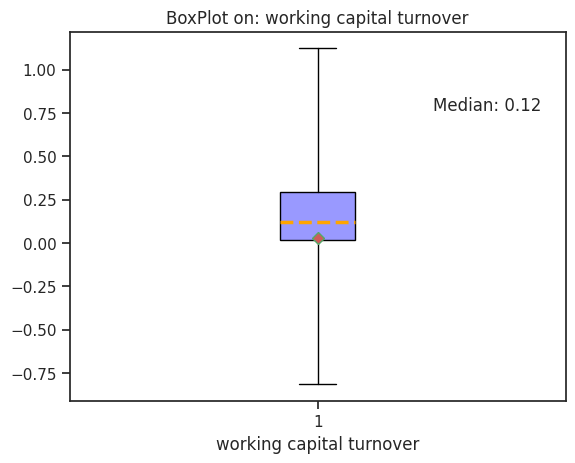

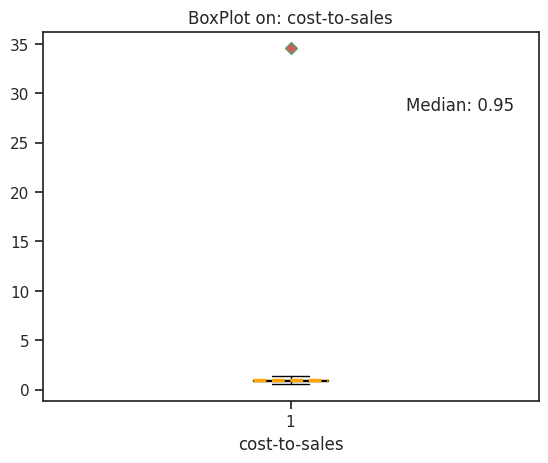

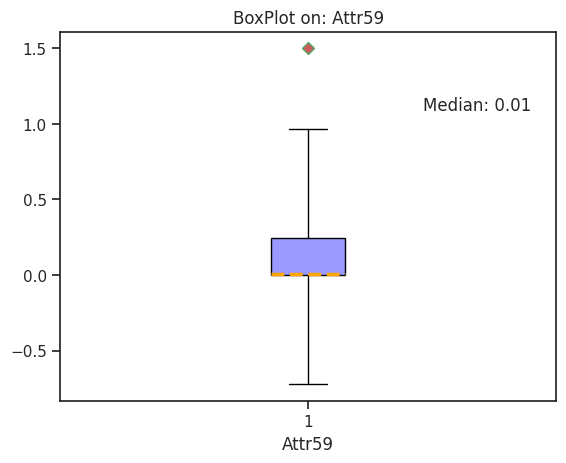

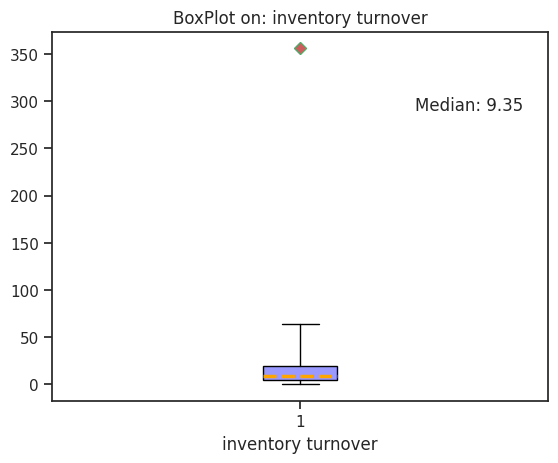

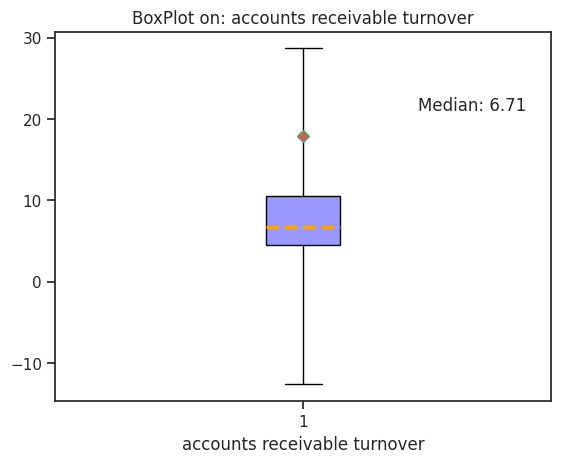

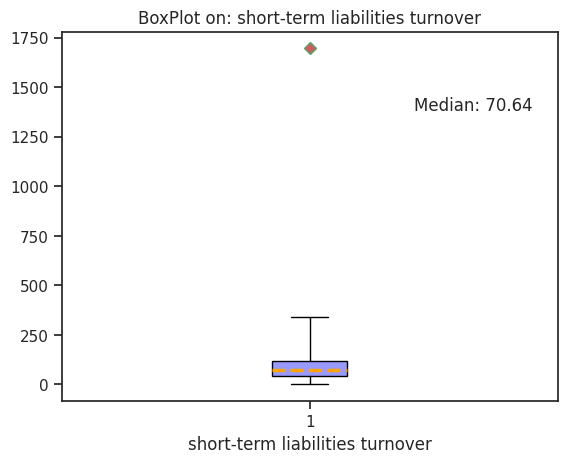

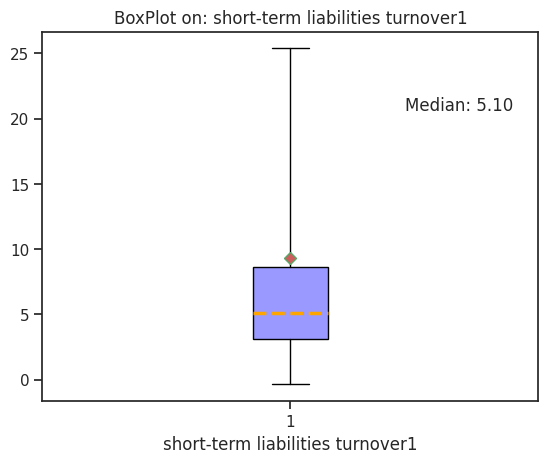

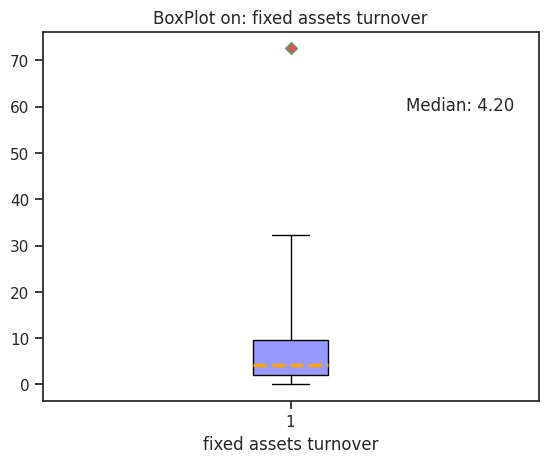

In [ ]:
# Fill missing values with 0
df_filled = df_concat.fillna(0)

# Create boxplot for each column
for col in column_list[1:64]:
    fig, ax = plt.subplots()
    ax.boxplot(x=df_filled[col],
               showfliers=False,
               whis=3,
               patch_artist=True,
               showmeans=True,
               boxprops={'color': 'black', 'facecolor': '#9999ff'},
               flierprops={'marker': 'o', 'markerfacecolor': 'red', 'color': 'black'},
               meanprops={'marker': 'D', 'markerfacecolor': 'indianred'},
               medianprops={'linestyle': '--', 'linewidth': 2.5, 'color': 'orange'})
    ax.tick_params(top=False, right=False)
    ax.set_xlabel(col)
    ax.set_title("BoxPlot on: " + col)

    # Calculate median and mean
    median = np.median(df_filled[col])
    mean = np.mean(df_filled[col])

    # Add median and mean to the plot
    ax.text(0.95, 0.8, f'Median: {median:.2f}', transform=ax.transAxes, ha='right', va='center')
    #ax.text(0.95, 0.7, f'Mean: {mean:.2f}', transform=ax.transAxes, ha='right', va='center')

    plt.show()

Interpretation of financial ratios can vary depending on the industry and specific standards for each company. However, here is a general interpretation of some financial ratios (we will interpret the median across the pool of companies):

    1- Debt-to-assets Ratio (Dette sur actifs) = 0.47: Indicates that 50% of companies (median) have 47% of assets financed by debt. The optimal threshold depends on the industry, but generally, a ratio below 0.5 is considered favorable, suggesting low dependence on debt. (50% of companies have low dependence on debt).

    2- Working Capital (Fonds de roulement) = 0.19: 50% of companies have limited capacity to cover their short-term obligations with their current assets. The optimal threshold is generally above 1.0, suggesting a more favorable situation where the company has enough liquidity to meet short-term obligations. (50% of companies do not have sufficient liquidity to meet short-term obligations).

    3- Current Ratio (Ratio actuel) = 1.55: 50% of companies have sufficient current assets to cover their short-term debts. The optimal threshold is generally above 1.0, indicating that the company has a safety margin to meet short-term obligations. (50% of companies have a safety margin to meet short-term obligations).

    4- Return on Equity (ROE) = 0.05: 50% of companies generate a 5% return on equity. The optimal threshold varies by industry, but generally, a higher ROE is desirable as it means the company is more profitable for shareholders.

    5- Return on Assets (ROA) = 0.06: 50% of companies generate a 6% return on assets. The optimal threshold depends on the industry, but generally, a higher ROA is favorable as it indicates the company is more efficient in using its assets to generate revenue.

    6- Equity-to-liability Ratio (Ratio capitaux propres/passif) = 1.05: 50% of companies have equity slightly exceeding their total liabilities. The optimal threshold varies by industry, but generally, a ratio above 1.0 is desirable as it indicates a stronger financial position. (50% of companies have a strong financial position).

    7- Asset Turnover (Rotation des actifs) = 1.21: 50% of companies generate 1.21 units of sales for each unit of assets. The optimal threshold depends on the industry, but generally, a higher asset turnover is favorable as it indicates better use of assets to generate sales.

    8- Equity-to-assets Ratio (Ratio capitaux propres/actifs) = 0.5: 50% of companies have half of their assets funded by equity. There is no universal threshold for this ratio as it can vary by industry. However, generally, a higher ratio is favorable as it indicates a larger proportion of assets funded by the company's equity.

    9- Coverage Ratio (Couverture) = 0.25: 50% of companies have profits covering only 25% of interest charges. The optimal threshold for this ratio depends on the industry and specific standards, but generally, a higher ratio is preferable as it suggests better ability for the company to meet interest obligations.

    10- everage Ratio (Effet de levier) = 2.10: 50% of companies use a high level of debt relative to their equity. There is no standard threshold for this ratio, but high leverage can increase the financial risk of the company.

    11- Inventory Turnover (Rotation des stocks) = 34.46: 50% of companies have their inventory turning approximately 34 times per year. The optimal threshold for this ratio depends on the specific industry, but generally, a higher ratio is favorable as it indicates more efficient use of inventory and better inventory management.

    12- Sales Growth Rate (Taux de croissance des ventes) = 0.99: 50% of companies have stable but not strongly accelerating growth. The optimal threshold for this ratio depends on the growth objectives of the company, but generally, a higher sales growth rate is desirable as it indicates faster business expansion.

    13- Acid-Test Ratio (Ratio acide-test) = 0.53: 50% of companies do not have adequate capacity to cover their short-term obligations.

    14- Quick Ratio (Ratio rapide) = 1.02: 50% of companies have sufficient liquid assets and accounts receivable to cover their short-term obligations. The optimal threshold for this ratio varies by industry, but generally, a quick ratio above 1.0 is desirable as it indicates adequate capacity to meet short-term obligations. (50% of companies have adequate capacity to meet short-term obligations).

    15- Total Debt to Assets Ratio (Dette totale aux actifs) = 0.34: 50% of companies are considered favorable as this ratio indicates low dependence on debt.


#### b- Probability Density

Probability density is a mathematical function used in statistics and probability to represent the distribution of values of a continuous random variable.

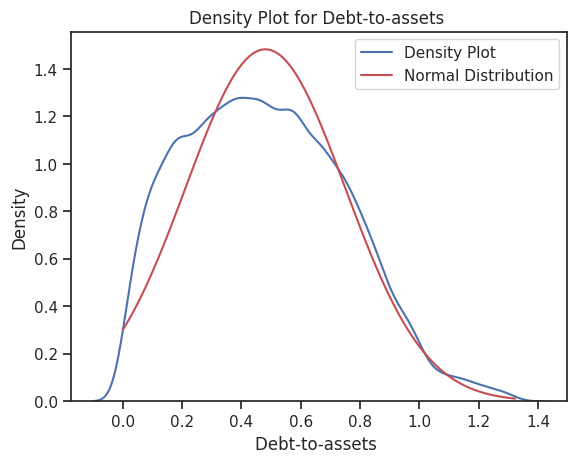

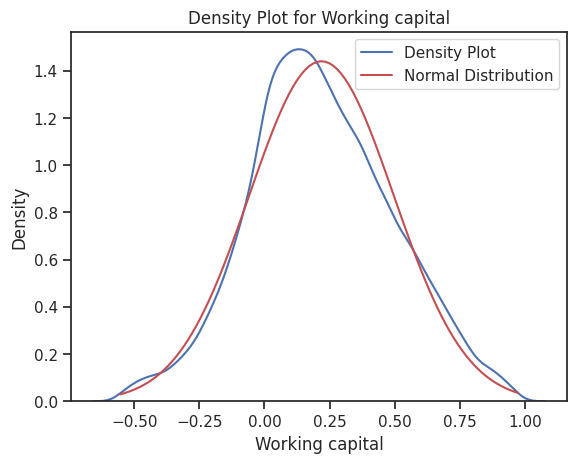

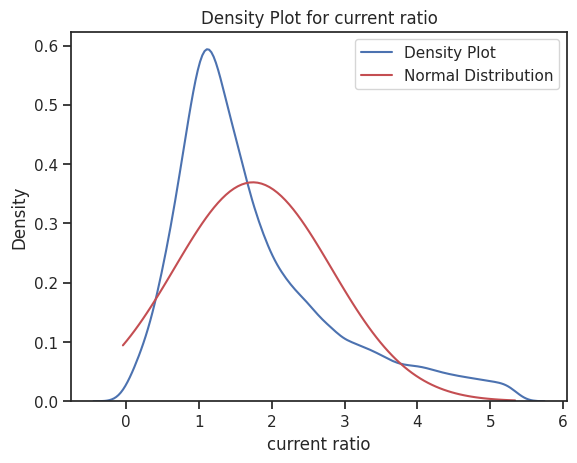

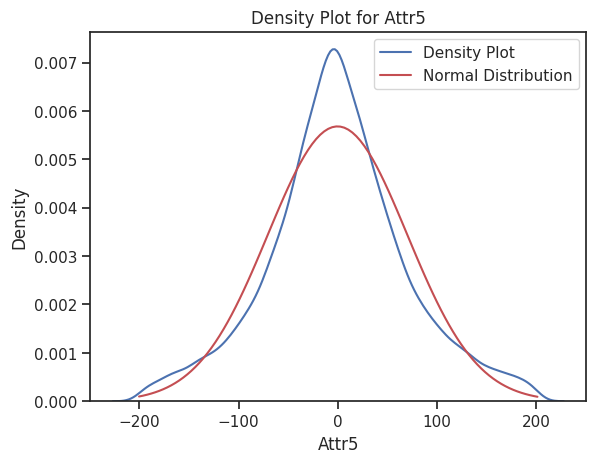

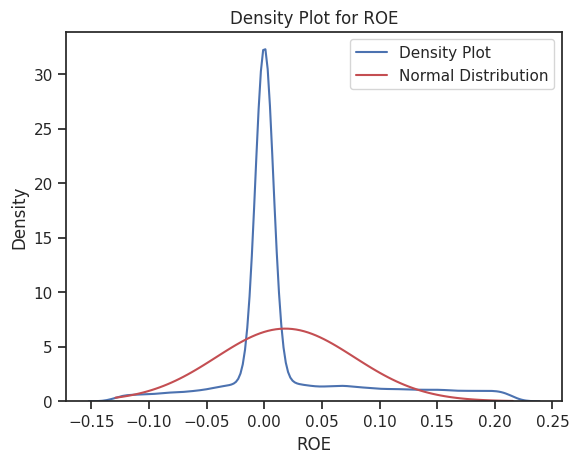

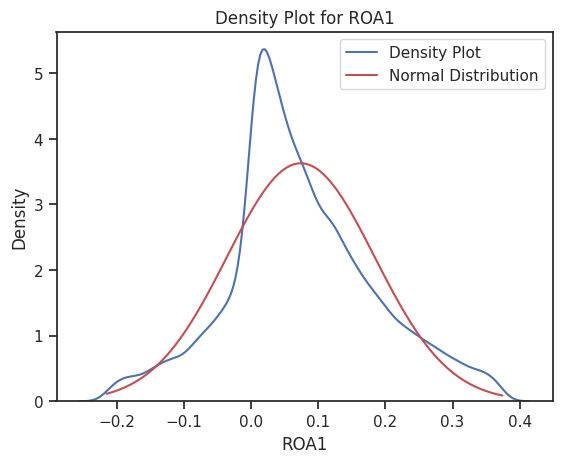

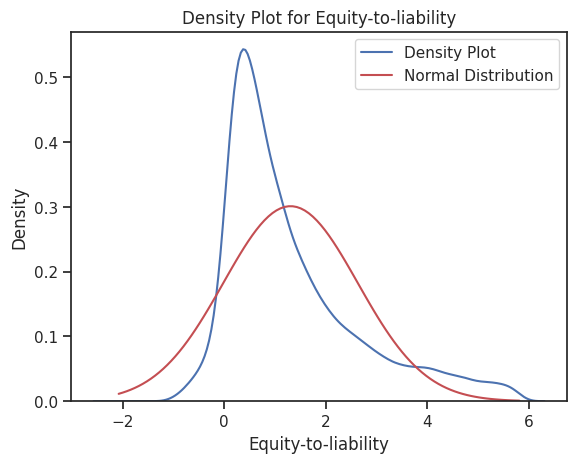

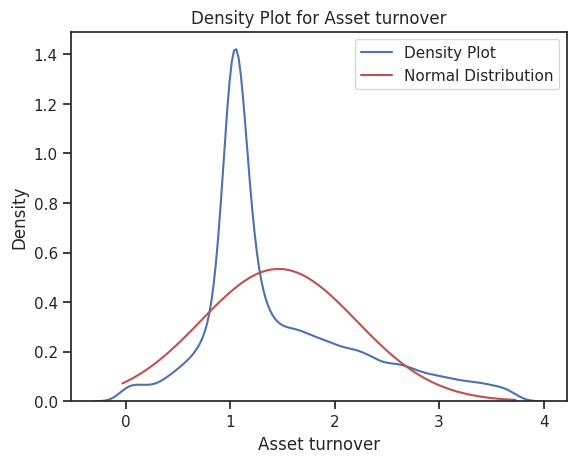

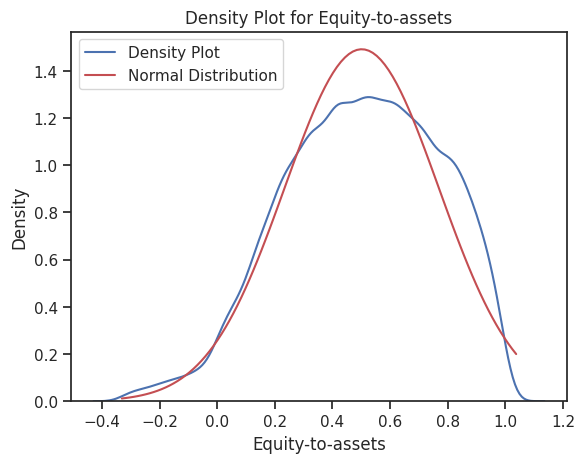

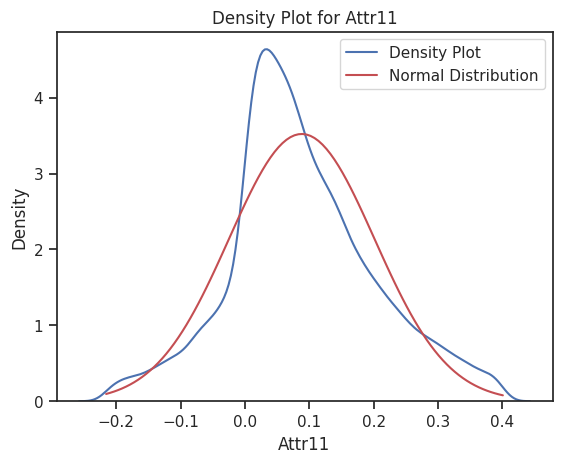

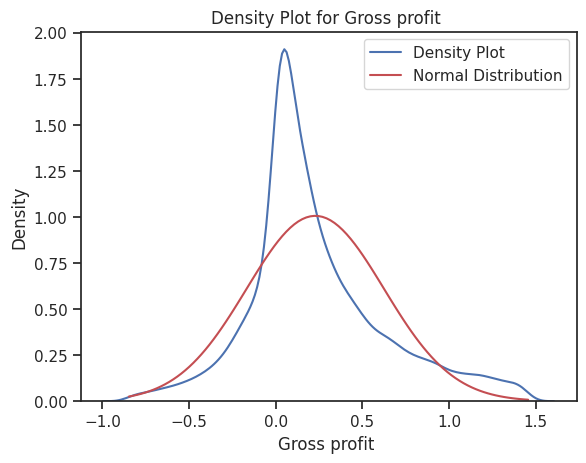

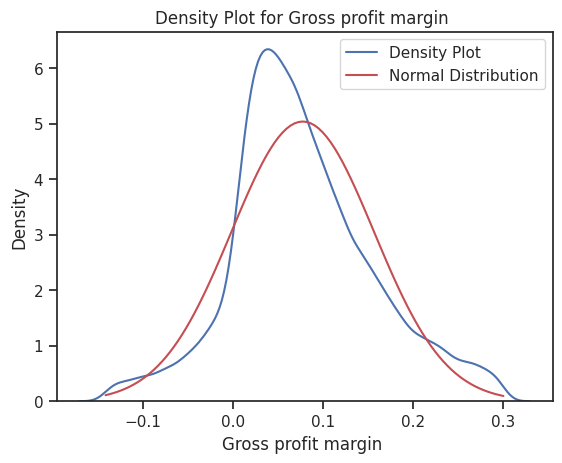

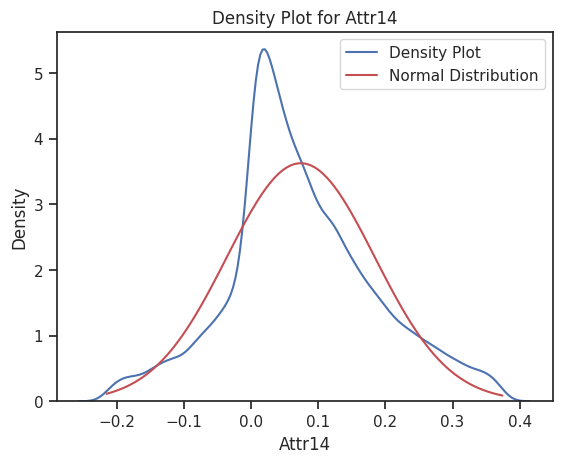

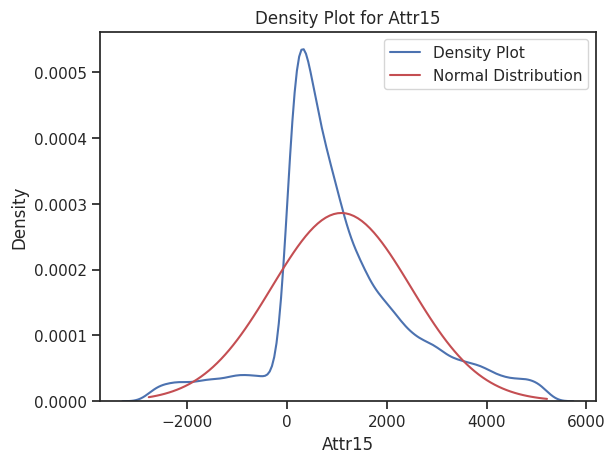

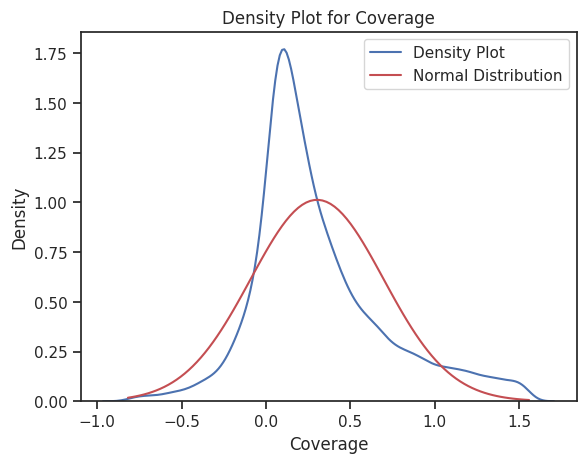

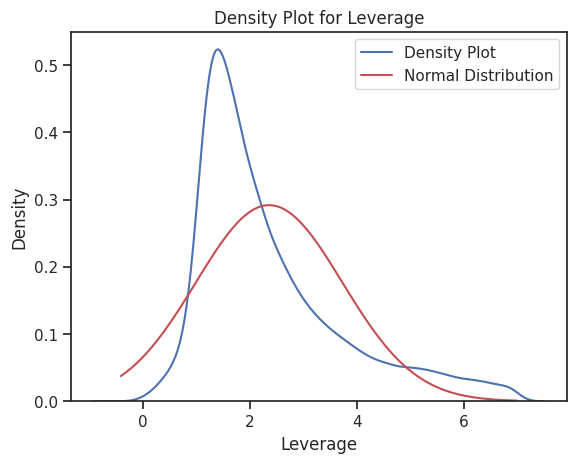

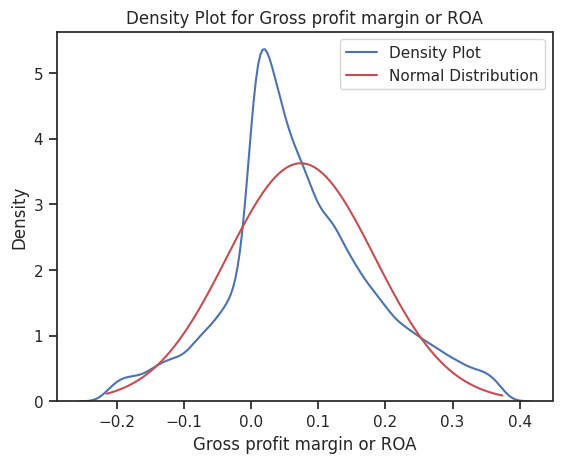

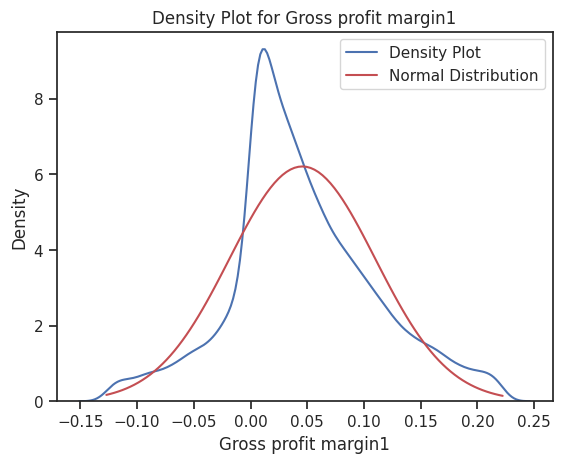

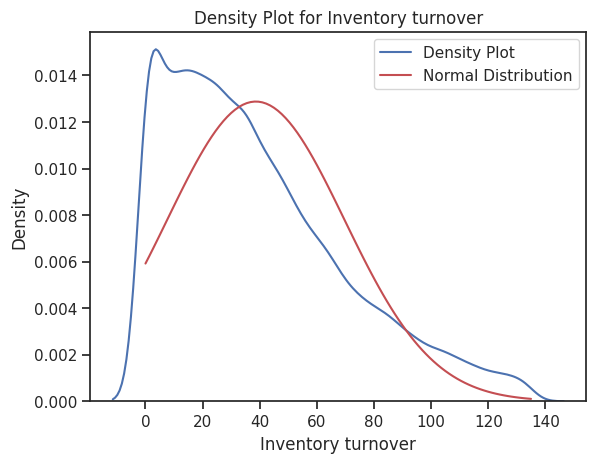

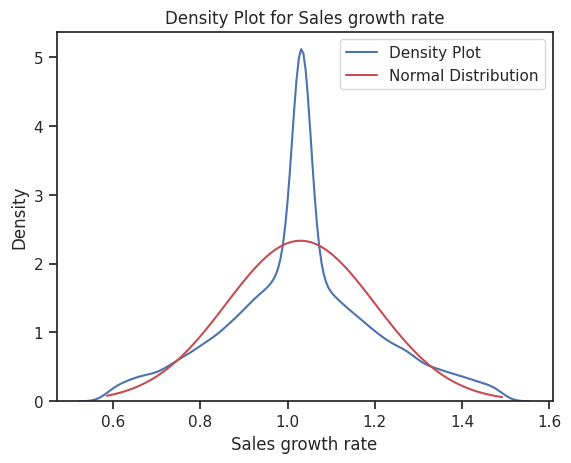

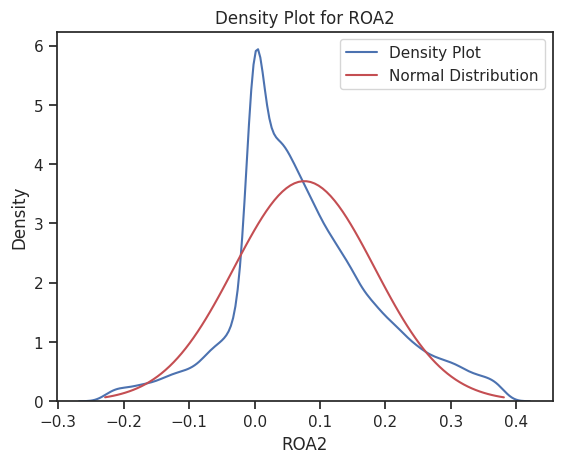

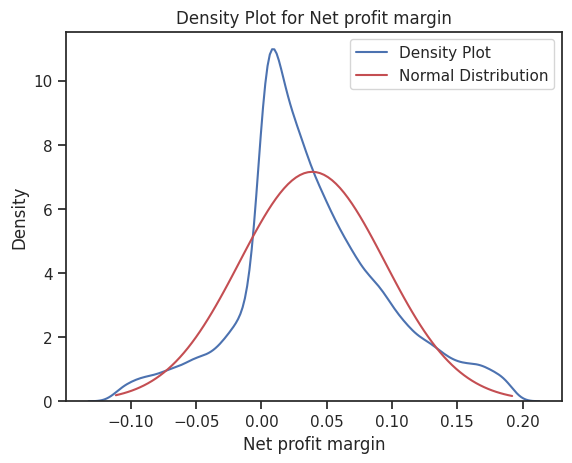

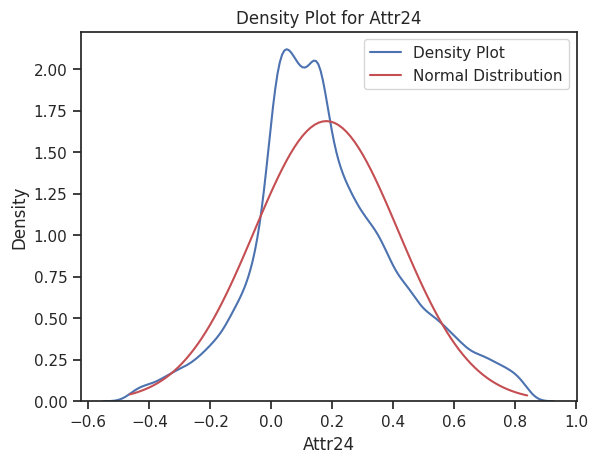

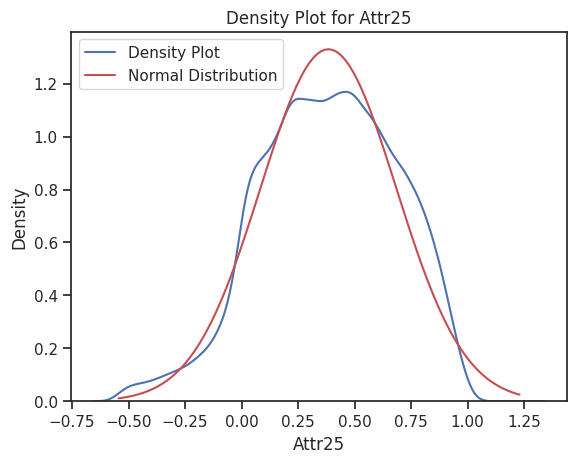

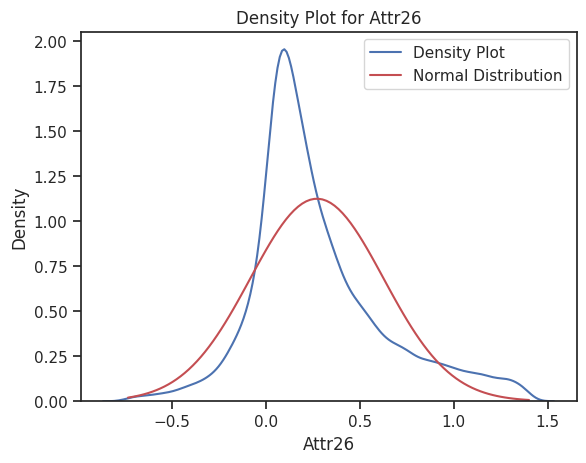

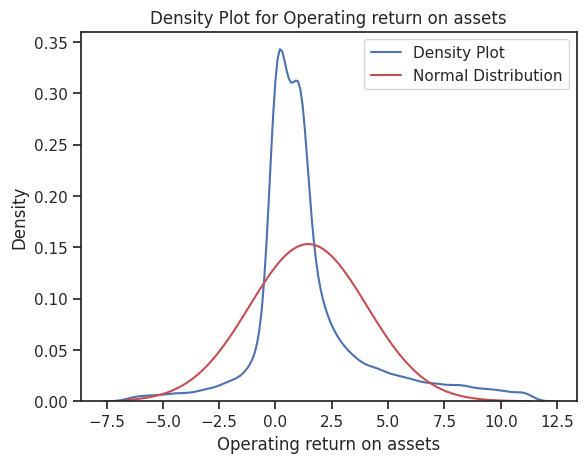

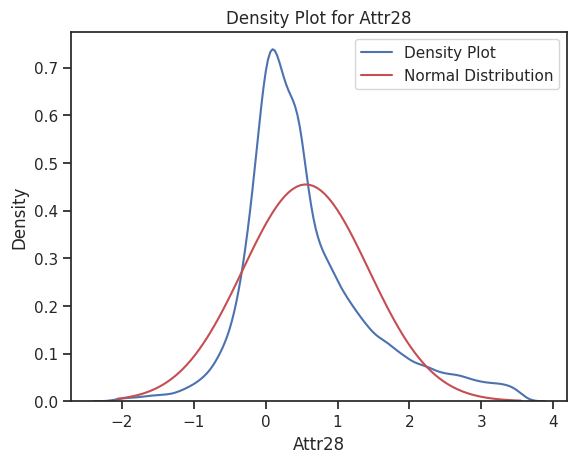

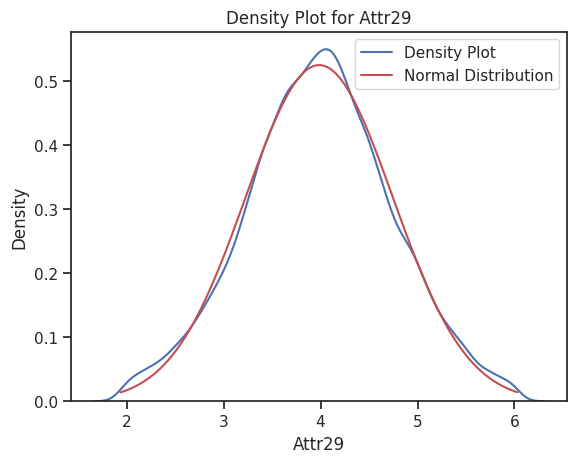

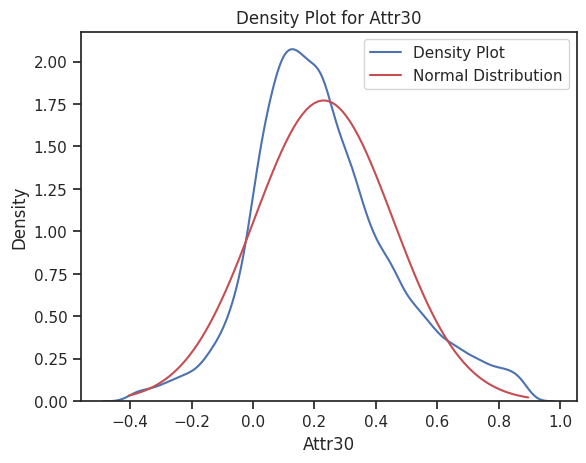

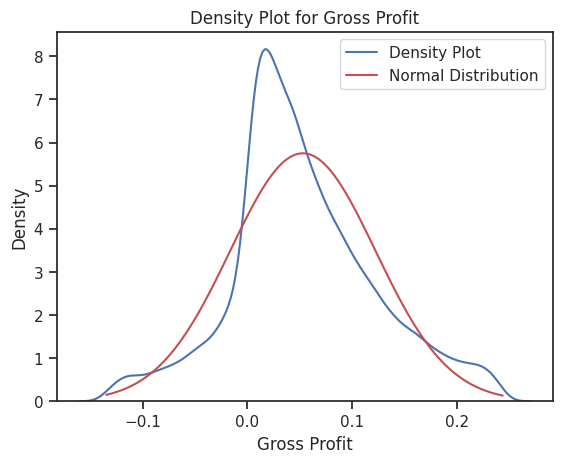

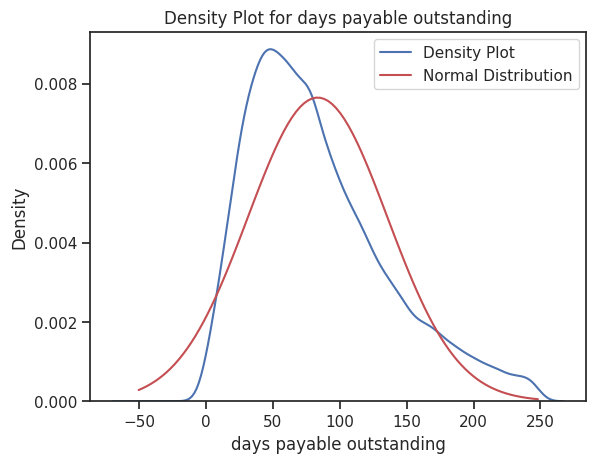

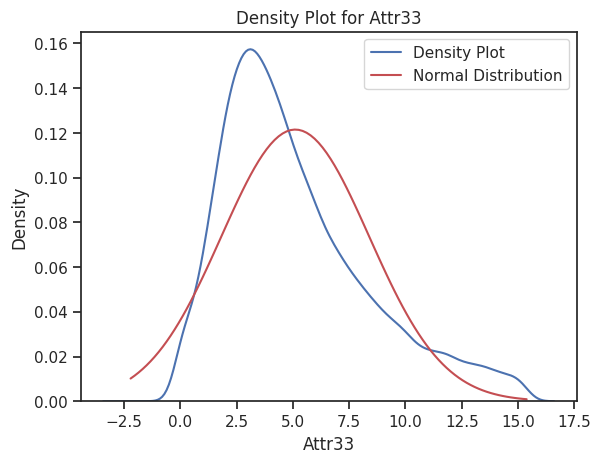

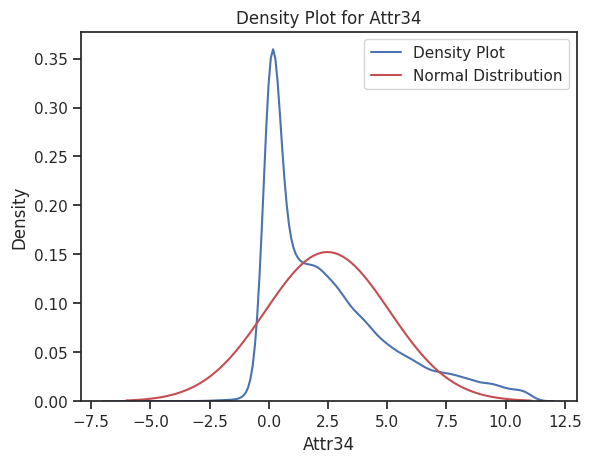

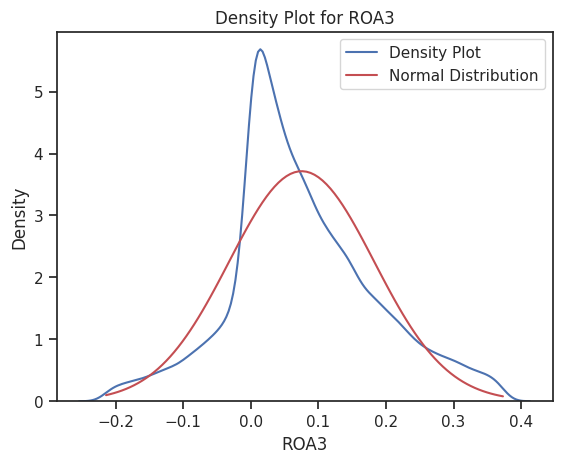

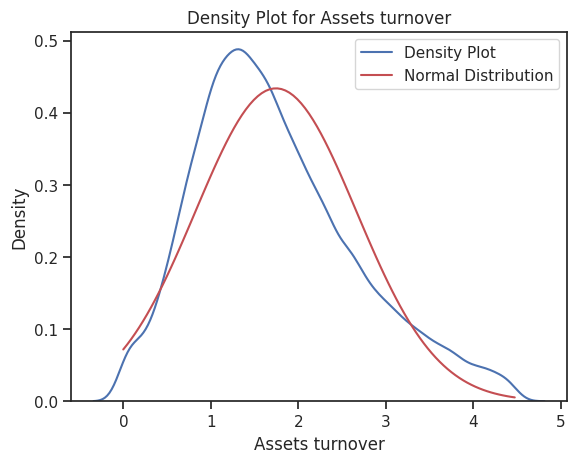

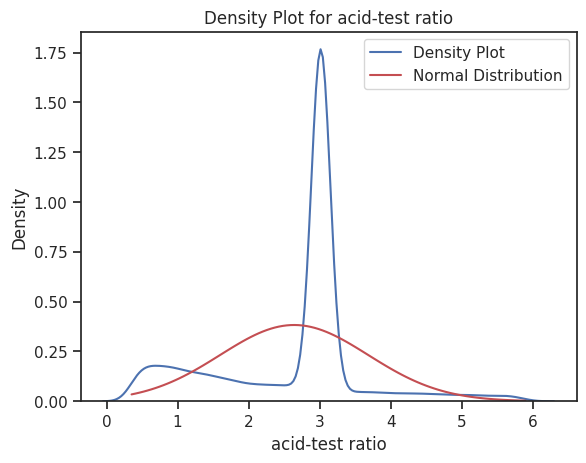

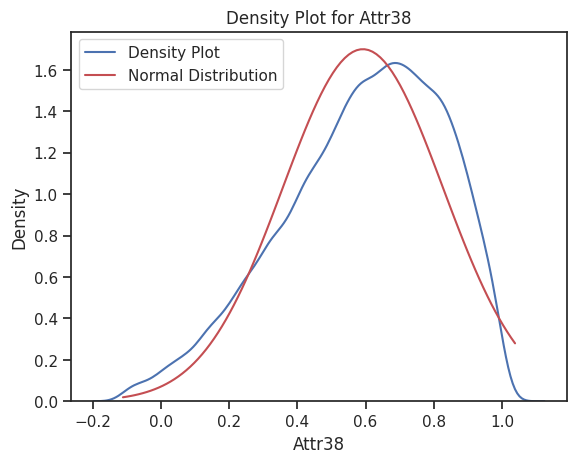

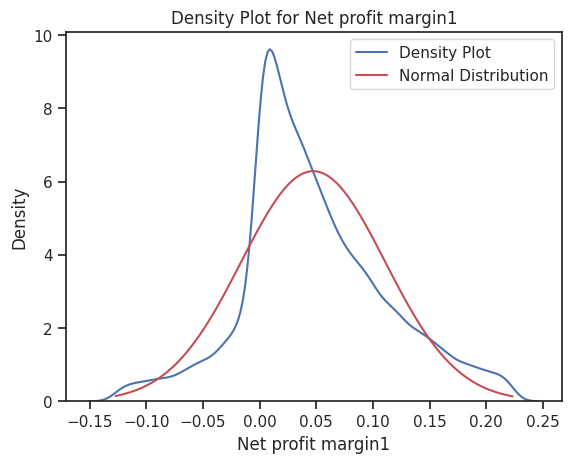

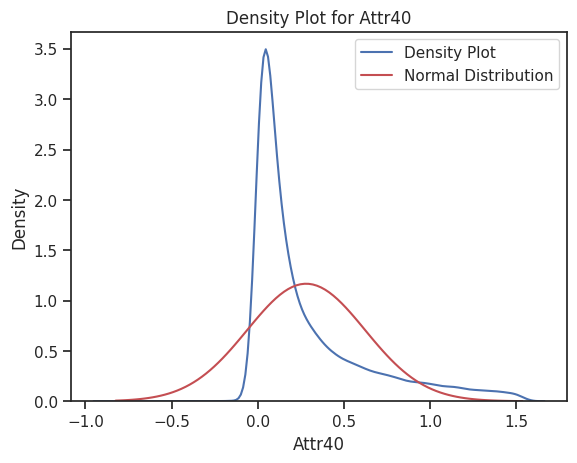

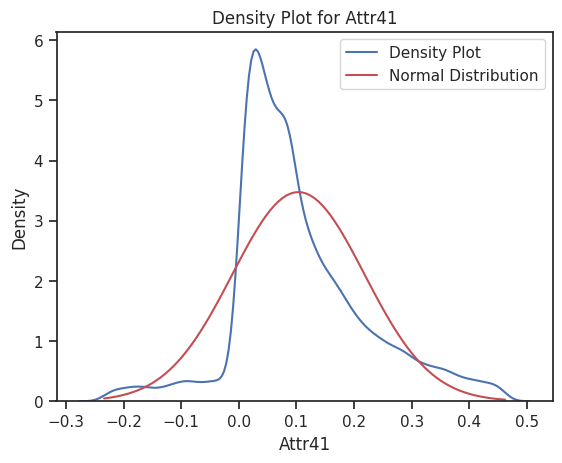

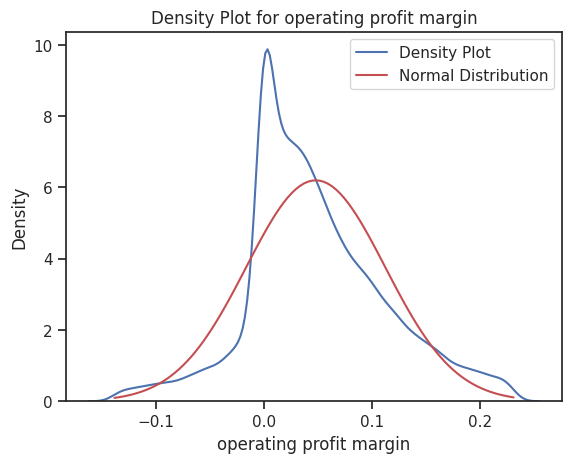

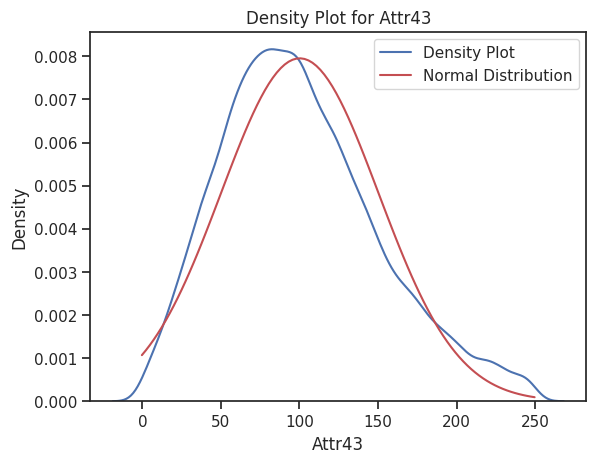

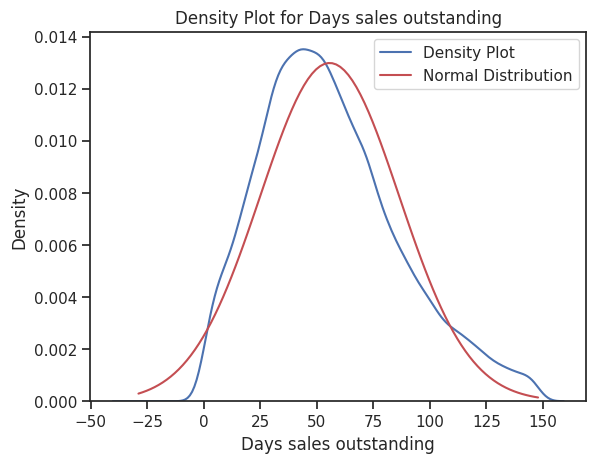

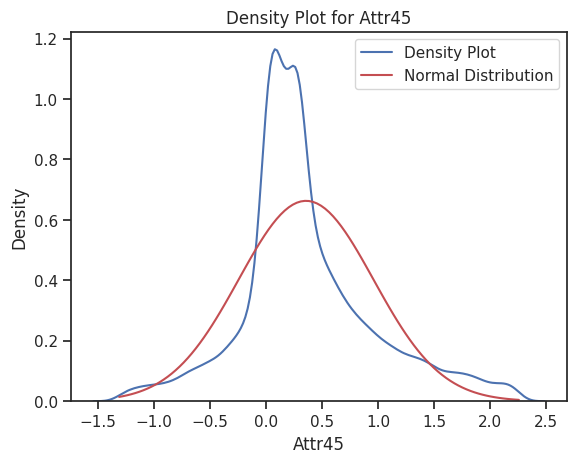

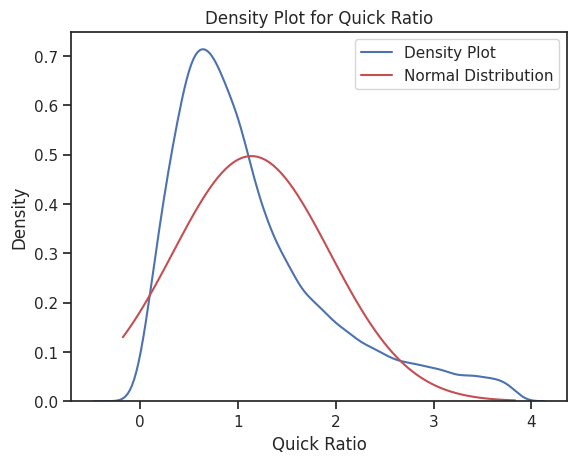

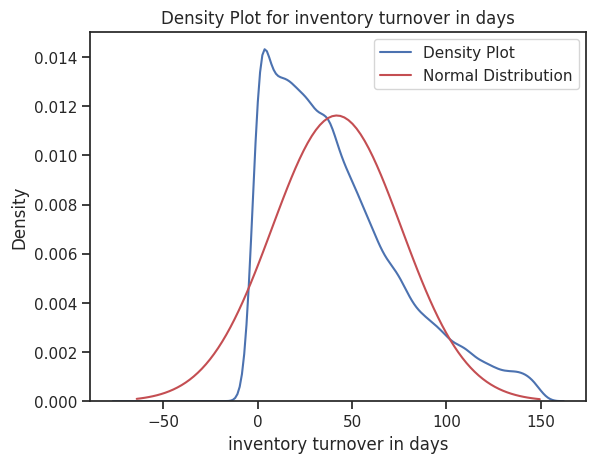

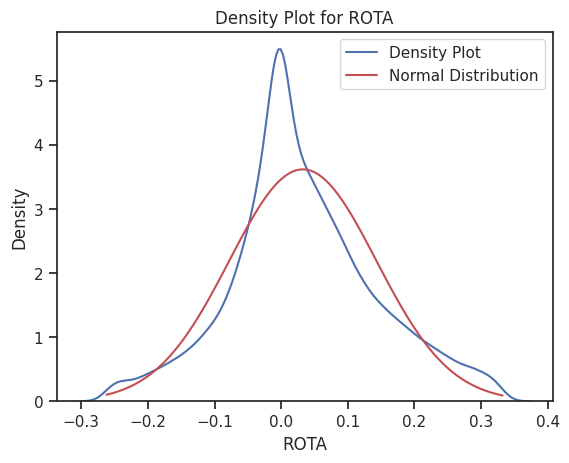

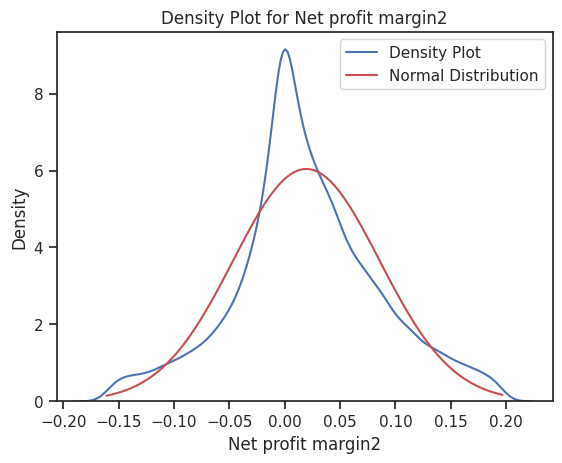

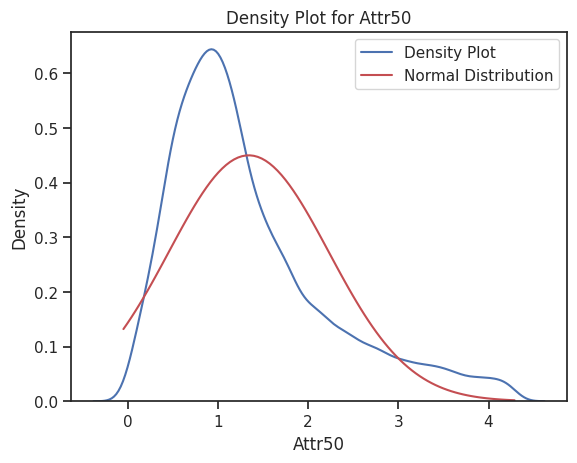

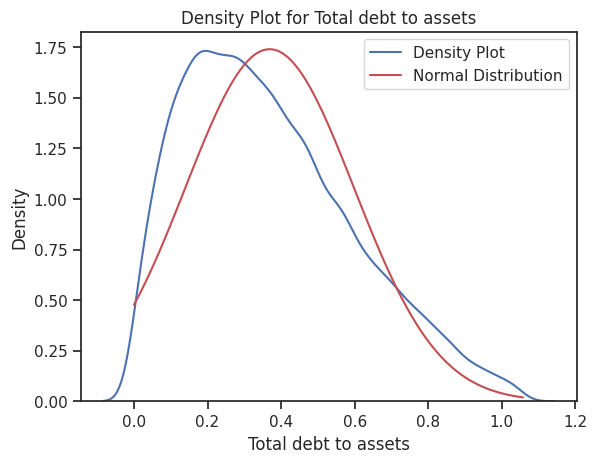

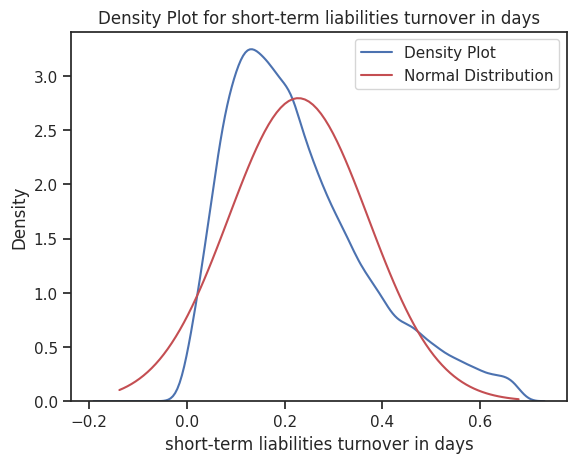

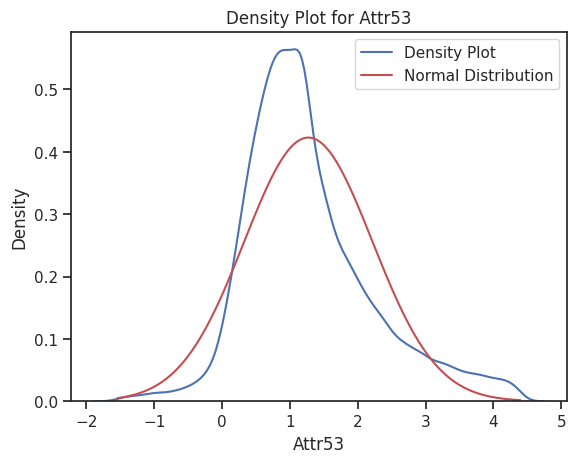

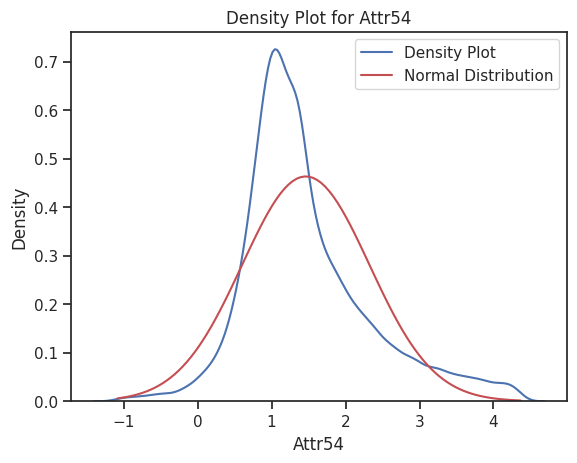

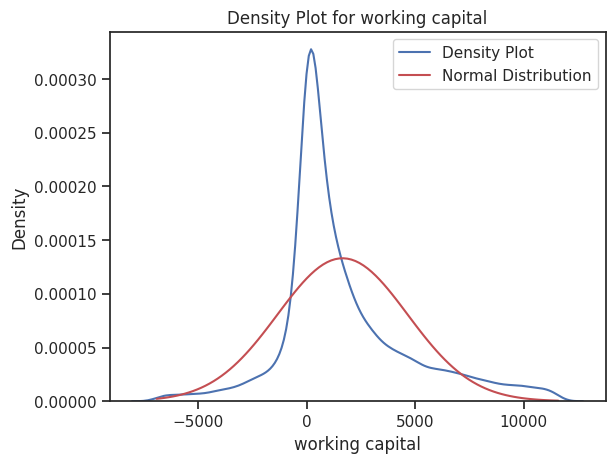

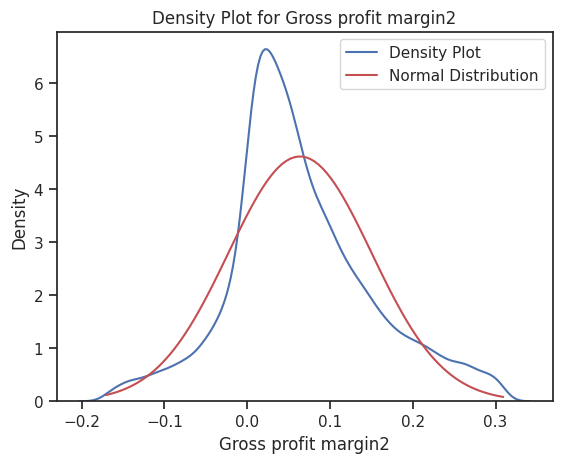

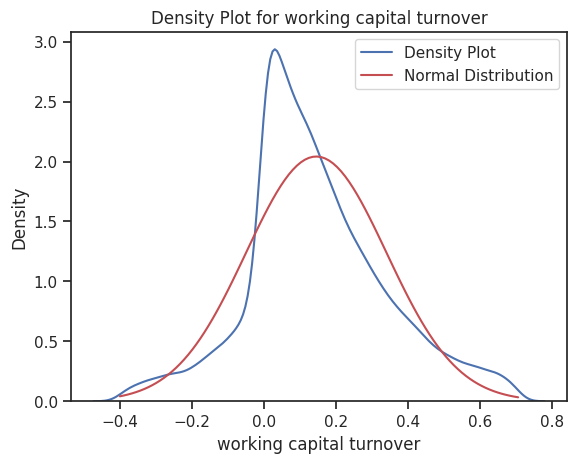

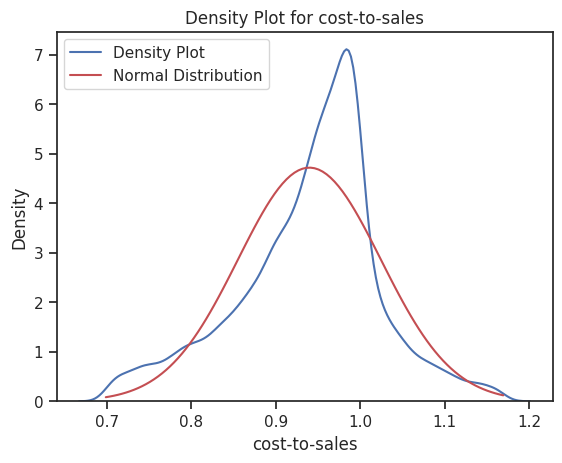

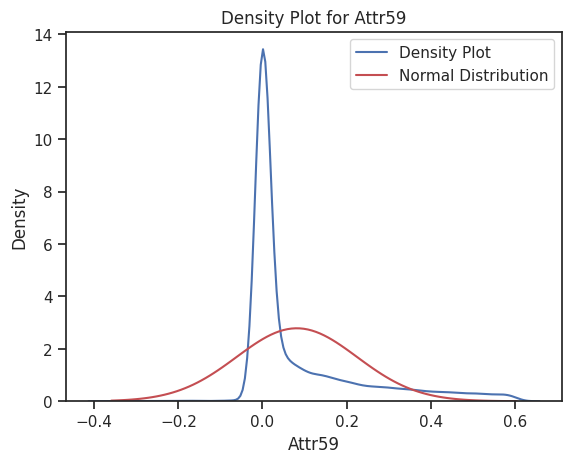

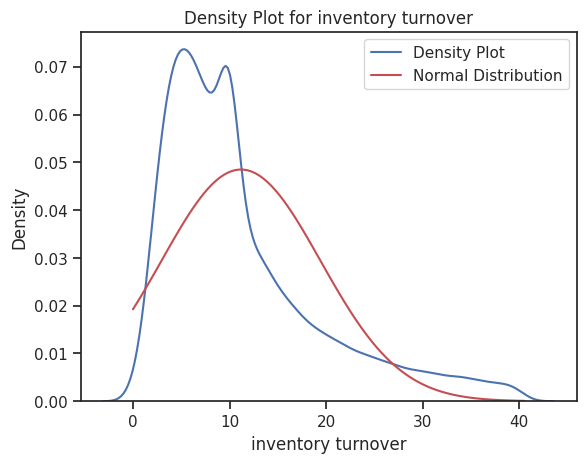

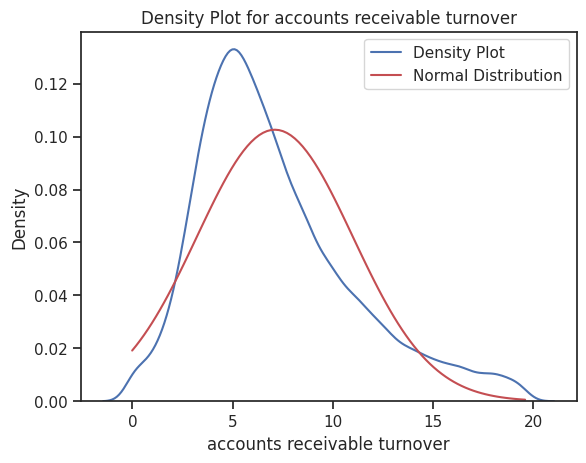

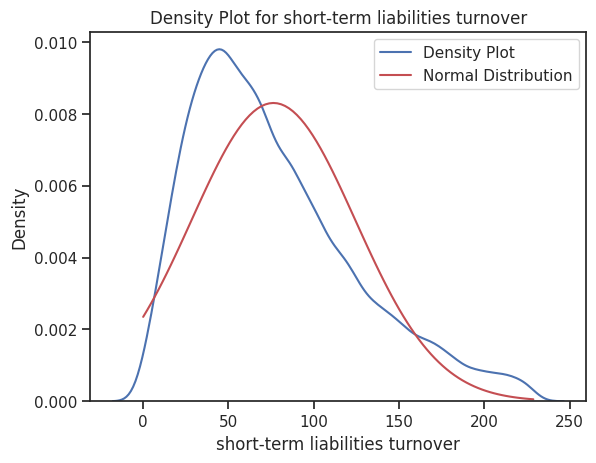

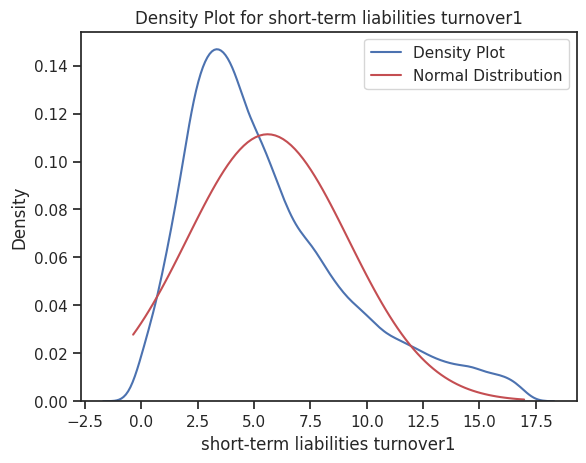

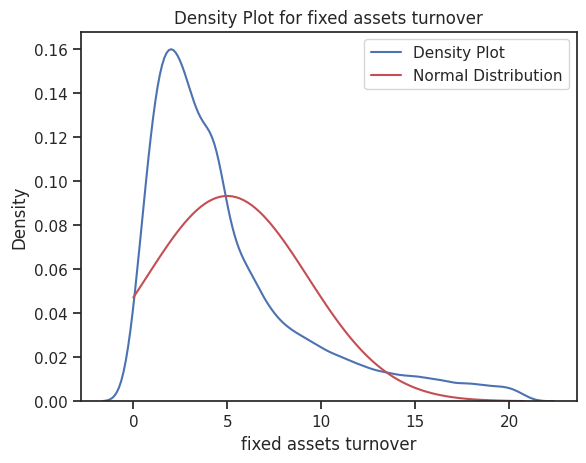

In [ ]:
from scipy.stats import norm
# Fill missing values with a specific value (e.g., median)
df_filled = df_concat.iloc[:, 1:64].fillna(df_concat.median())

# Remove outliers
q1 = df_filled.quantile(0.25)
q3 = df_filled.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_outliers_removed = df_filled[(df_filled >= lower_bound) & (df_filled <= upper_bound)]

sns.set(style="ticks")

# Construct density plot for each column
for column in df_outliers_removed.columns:
    # Get cleaned data of the column
    cleaned_data = df_outliers_removed[column]

    # Exclude non-finite values from the calculation
    cleaned_data = cleaned_data[np.isfinite(cleaned_data)]

    # Calculate parameters of the normal distribution (mean and standard deviation)
    mean, std = norm.fit(cleaned_data)

    # Generate a sample of values for the probability density function of the normal distribution
    x = np.linspace(cleaned_data.min(), cleaned_data.max(), 100)
    y = norm.pdf(x, mean, std)

    # Plot the density plot with the normal distribution
    plt.figure()
    sns.kdeplot(data=cleaned_data, label="Density Plot")
    plt.plot(x, y, 'r-', label="Normal Distribution")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.title('Density Plot for ' + column)
    plt.show()

Probability density provides insight into the distribution of the variable, allowing us to make decisions about the applied model and the appropriate transformation to achieve effective results. We observe that, in practice, only the Working Capital and Days Sales Outstanding follow a normal distribution. Hence, standardization (normalization) of the data will be a crucial step before moving on to modeling to ensure the homogeneity of variables.

#### d- Class Distribution of Companies (Target)

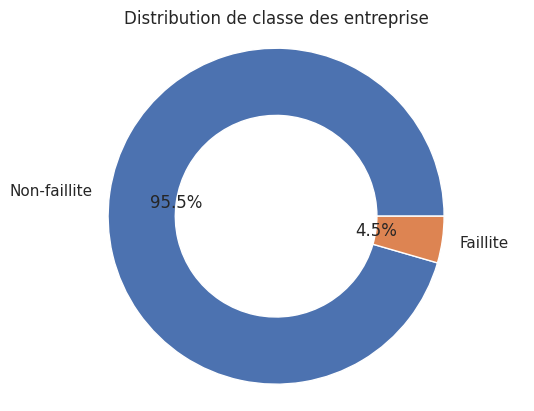

In [ ]:
# Count the frequencies of each value
value_counts = df_concat['target'].value_counts()

# Create the doughnut chart
plt.pie(value_counts, labels=['Non-Bankruptcy', 'Bankruptcy'], wedgeprops=dict(width=0.4), autopct='%1.1f%%')

# Draw a white circle at the center to create the donut hole
circle = plt.Circle((0, 0), 0.3, color='white')
plt.gca().add_artist(circle)

# Add a title
plt.title('Class Distribution of Companies')

# Equal aspect ratio ensures that the pie is drawn as a circle
plt.axis('equal')

# Display the plot
plt.show()

In [ ]:
print('Number of Bankrupt Companies?\n',
      df_concat['target'].value_counts())
print('Percentage of Bankrupt Companies?\n',
      df_concat['target'].value_counts(normalize=True))

Le nombre des entreprises défaillantes?
 0    35814
1     1681
Name: target, dtype: int64
Le pourcentage des entreprises defaillantes?
 0    0.955167
1    0.044833
Name: target, dtype: float64


The present database is a "Low Default Portfolio" (LDP), where the default class (bankruptcy) constitutes the minority class (4.8%).

### 2.2. Bivariate

Bivariate analysis, in our case, can be conducted through:

    * Graphic analysis: boxplot (crossing between ratios and the target class); scatterplot (scatter plot between ratios)
    * Statistical analysis: correlation (between ratios); ANOVA (ratios vs. target); regression

#### a- Graphic analysis

##### Pairwise intersection of variables

In [ ]:
from scipy.stats import linregress

# Remove missing values from the DataFrame
df_cleaned = df_concat.dropna().copy()
df_cleaned = df_cleaned.iloc[:, 1:64].dropna()

# Remove outlier values from the columns
q1 = df_cleaned.quantile(0.25)
q3 = df_cleaned.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_cleaned = df_cleaned[((df_cleaned >= lower_bound) & (df_cleaned <= upper_bound)).all(axis=1)]

# Create scatter plots for each pair of columns
for i in range(len(df_cleaned.columns)):
    for j in range(i + 1, len(df_cleaned.columns)):
        x = df_cleaned.columns[i]
        y = df_cleaned.columns[j]

        # Fit a regression line to the scatter plot
        sns.regplot(data=df_cleaned, x=x, y=y, scatter_kws={'alpha': 0.5})

        # Calculate regression parameters
        slope, intercept, r_value, p_value, std_err = linregress(df_cleaned[x], df_cleaned[y])

        # Add the equation of the regression line
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        plt.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')

        # Add labels and title
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"Scatter Plot: {x} vs {y}")

        # Show the plot
        plt.show()

The scatter plots above present the pairwise relationships between the variables in the current case study. Three types of relationships are noteworthy:

    1- Nearly linear relationship (straight line) between:
        * "debt to assets" x "equity to assets": indicating that debt is inversely proportional to equity,
        * "debt to assets" x "Attr25" (where Attr25 = (equity - share capital) / total assets),
        * "ROA" x "Attr11," "Attr14," and "Gross profit": suggesting that the return on assets is proportional to gross margin.

    2- Non-linear relationship (hyperbola) between:
        * "debt to assets" x "equity to liabilities": signifying that debt is inversely proportional to liabilities,
        * "debt to assets" x "Leverage": implying that debt is inversely proportional to leverage, contradicting the theory that states When a company uses debt to finance its operations, it increases its leverage.

    3- Random scatter plot.

#### b- Statistical Analysis

#####  Relation ROA-ROE

Hypothesis: If a company has no debt, then the total assets equal the equity, and therefore, the ROA (Return on Assets) and ROE (Return on Equity) are equal.

In [ ]:
# Calculate the correlation between ROA and ROE
correlation = df_concat['ROA'].corr(df_concat['ROE'])

# Print the correlation coefficient
print("Correlation ente ROA et ROE :", correlation)

Correlation ente ROA et ROE : 0.05800399260790483


##### Debt Ratio vs. Financial Risk

Hypothesis: A heavily indebted company may have a higher financial risk.

In [ ]:
# It's a quantitative variable (debt ratio) and qualitative variable
# (financial risk ) so ANOVA is appropriate approach

df_cleaned = df_concat.dropna().copy()
q1 = df_cleaned['Debt-to-assets '].quantile(0.25)
q3 = df_cleaned['Debt-to-assets '].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_cleaned = df_cleaned[(df_cleaned['Debt-to-assets '] >= lower_bound) & (df_cleaned['Debt-to-assets '] <= upper_bound)]
# Perform the ANOVA
anova_result = stats.f_oneway(df_cleaned[df_cleaned['target'] == '1']['Debt-to-assets '], df_cleaned[df_cleaned['target'] == '0']['Debt-to-assets '])

# Print the ANOVA result
print("ANOVA Result:")
print("F-value:", anova_result.statistic)
print("p-value:", anova_result.pvalue)


ANOVA Result:
F-value: 160.00779881599976
p-value: 1.659033818526037e-36


=> on a le p-value < 5%, donc on accepte l'hypothese alternative qui stipule la présence d'une variablité au niveau des classe, c-à-d une entreprise fortement endettée peut avoir un risque financier plus élevé.

### 2.3. Multivariate

Multivariate analysis, in our case, can be conducted through:

    * Graphic analysis: scatterplot (scatter plot between ratios)
    * Statistical analysis: correlation matrix; Principal Component Analysis (PCA)

<ipython-input-49-ea795011ea50>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_concat.corr().abs()


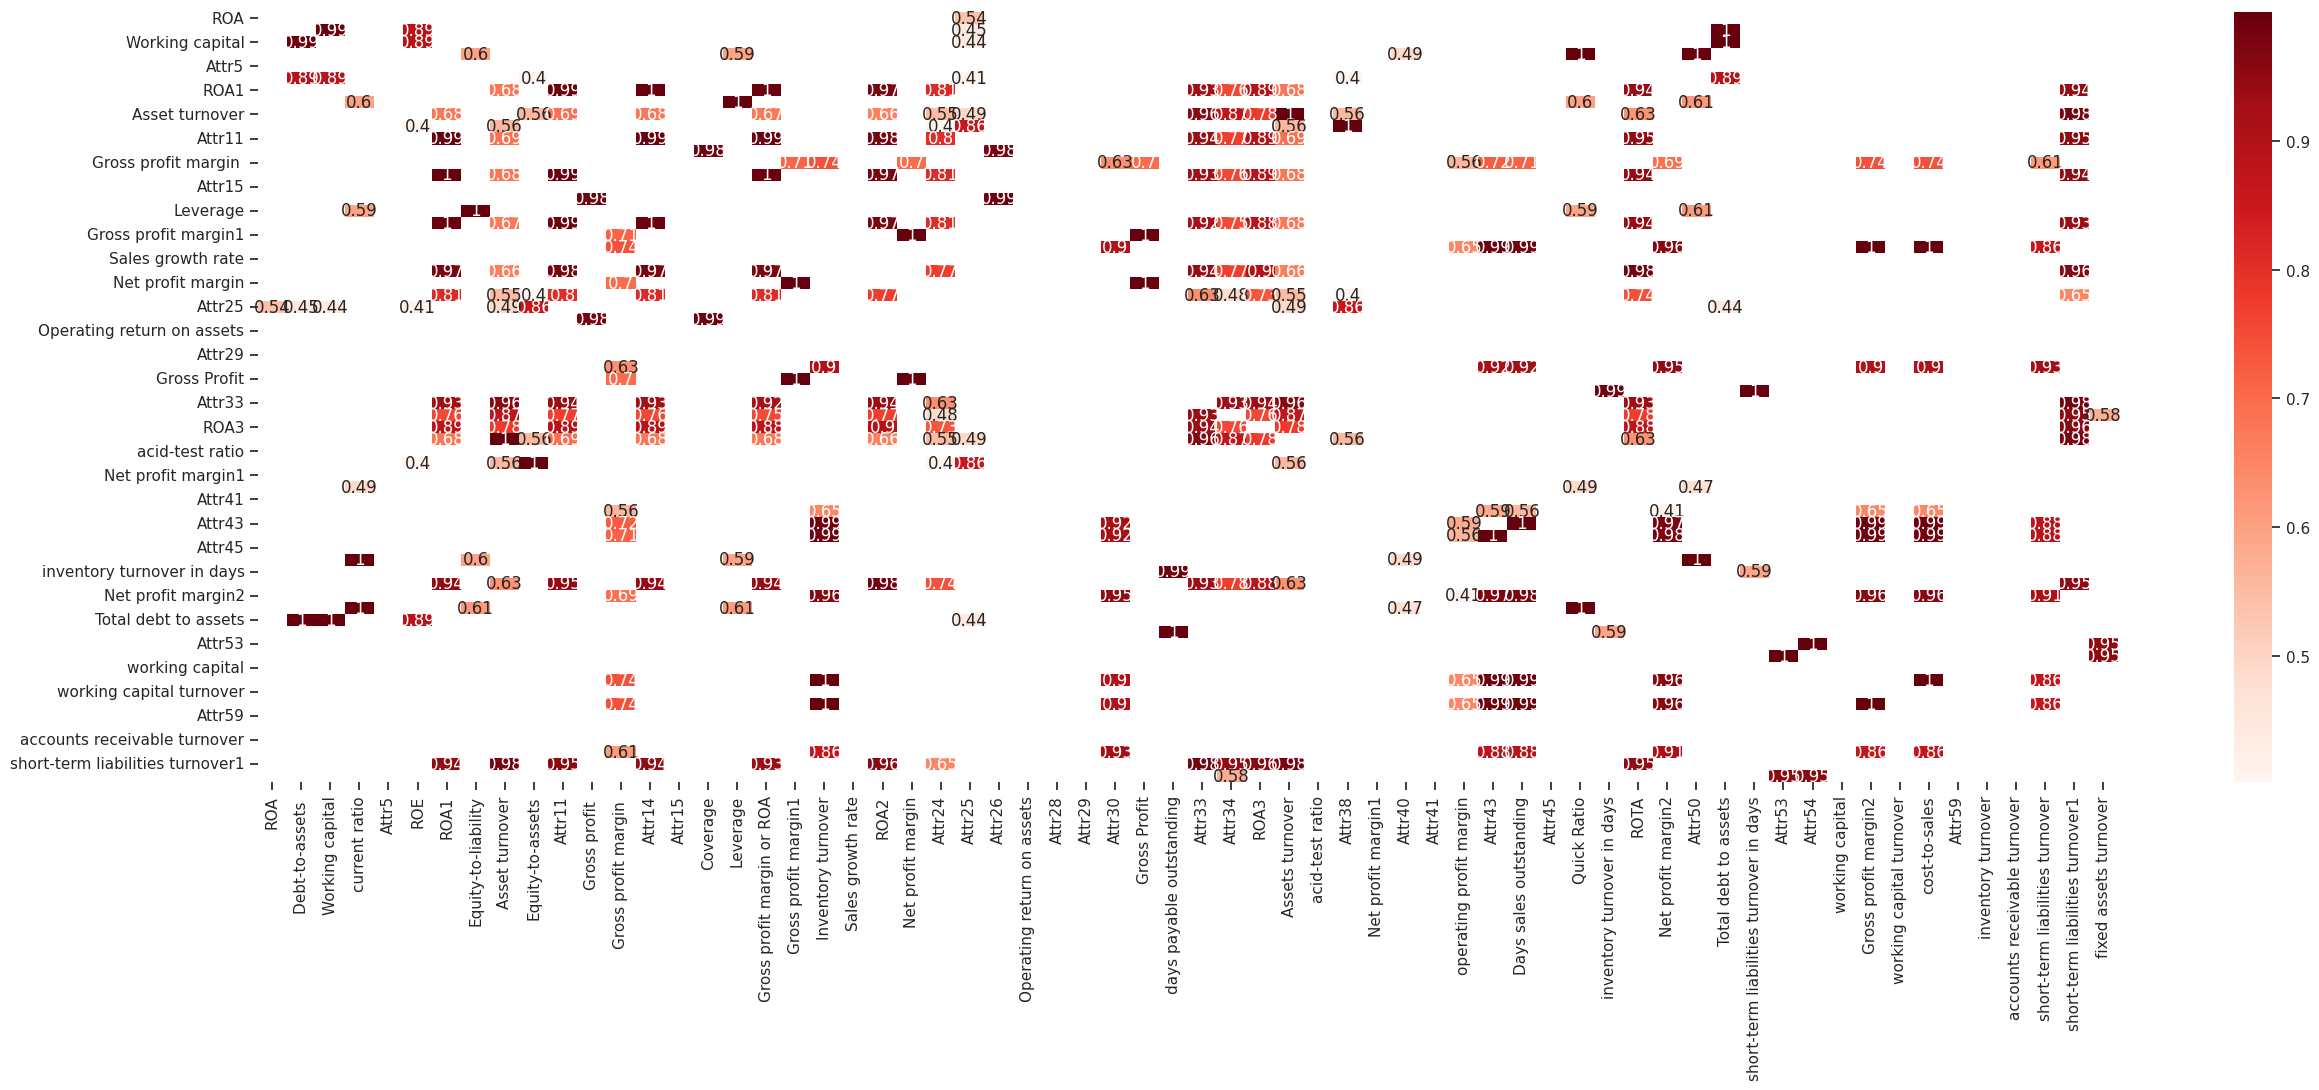

In [ ]:
# create correlation matrix with abs values
corr_matrix = df_concat.corr().abs()

# change this value as needed, if 0.5 does not work for your scenario
threshold = 0.4

filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)]

plt.figure(figsize=(30,10))
sns.heatmap(filtered_corr_df, annot=True, cmap="Reds")
plt.show()

<ipython-input-50-f7957d2b9d33>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_concat.corr()
<ipython-input-50-f7957d2b9d33>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_filtered.corr(), annot=False, cmap='coolwarm')


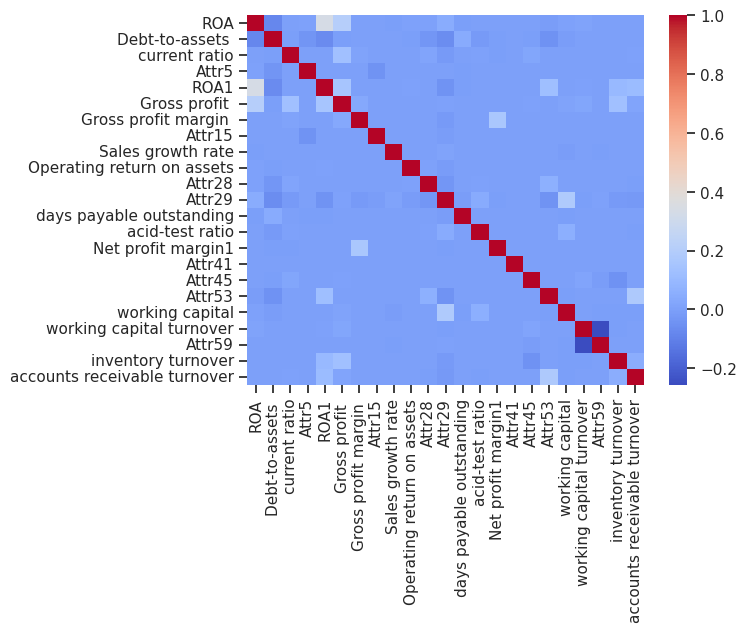

In [ ]:
# Compute the correlation matrix
corr_matrix = df_concat.corr()

# Drop variables with correlations above 0.4
variables_to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.4:
            variables_to_drop.add(corr_matrix.columns[j])

df_filtered = df_concat.drop(columns=variables_to_drop)

# Create a heatmap of the correlation matrix
sns.heatmap(df_filtered.corr(), annot=False, cmap='coolwarm')

# Show the plot
plt.show()

## 3- Data processing

This phase will be divided into three subsections:

    * Correct anomalies (missing values, outliers, and multicollinearity)

    * Select relevant variables

    * Split the data (training data and test data)

### 3.1. Correction of anomalies

#### a- Missing values

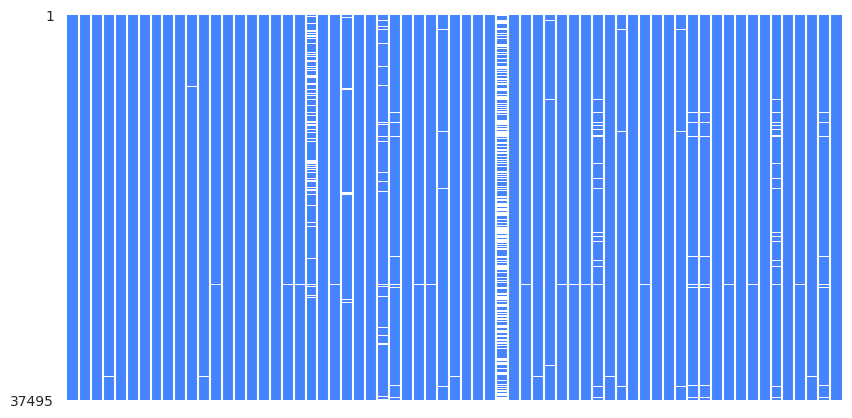

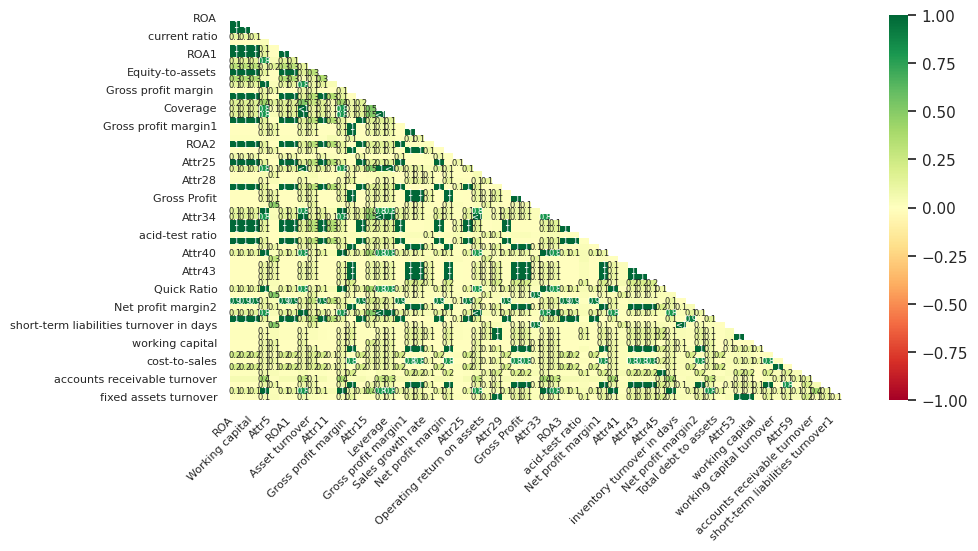

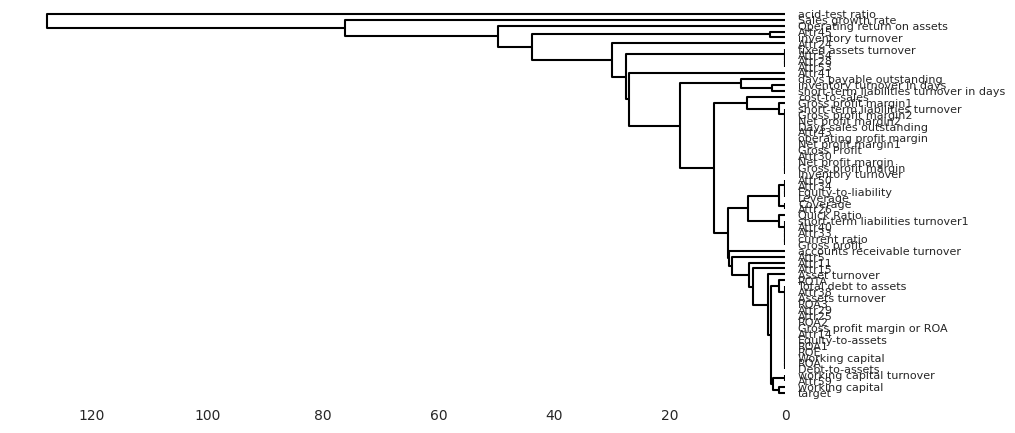

In [ ]:

# Check for nulls.
df_concat.isnull().sum()
# Visualize missing values as a matrix
msno.matrix(df_concat, sparkline=False, figsize=(10,5), fontsize=8, color=(0.27, 0.52, 1.0));

# Visualize the correlation between the number of
# missing values in different columns as a heatmap
msno.heatmap(df_concat, cmap="RdYlGn", figsize=(10,5), fontsize=8);
msno.dendrogram(df_concat, figsize=(10,5), fontsize=8);

Once we have identified the missing values, we need to correct them. In this context, we have adopted two scenarios:

    * If the rate of missing values is greater than 35%: we will delete the variable. This choice refers to the distribution of the variable; if we impute it, we will have an imputation rate higher than the observation rate, which poses a risk of changing the characteristic of the variable.

    * If the rate of missing values is less than 35%, we will perform imputation.

Note: There are several imputation techniques:

    * Simple imputation (replace with: mean, variance, mode, median, ...)
    * Modeling imputation (regression, KNN, PCA, Kalman filter, ...)

=> The decision on the effectiveness of the chosen technique will be based on the difference between the density before and after imputation.


In [ ]:
# Missing values ratio
missing_percentages = df_concat.isnull().mean() * 100

# Filter the variables with a missing value rate greater than 35%.
variables_to_drop = missing_percentages[missing_percentages > 35].index.tolist()
variables_to_imput = missing_percentages[(missing_percentages >= 0) & (missing_percentages <= 35)].index.tolist()
# Display the variables to be deleted
print("Variables with a missing value rate greater than 35%:")
print(variables_to_drop)
print("Individuals with a missing value rate between 0% and 35% :")
print(variables_to_imput)

Variables avec un taux de valeurs manquantes supérieur à 35%:
['acid-test ratio']
Individus avec un taux de valeurs manquantes entre 0% et 35% :
['ROA', 'Debt-to-assets ', 'Working capital', 'current ratio', 'Attr5', 'ROE', 'ROA1', 'Equity-to-liability', 'Asset turnover', 'Equity-to-assets', 'Attr11', 'Gross profit ', 'Gross profit margin ', 'Attr14', 'Attr15', 'Coverage', 'Leverage', 'Gross profit margin or ROA', 'Gross profit margin1', 'Inventory turnover', 'Sales growth rate', 'ROA2', 'Net profit margin', 'Attr24', 'Attr25', 'Attr26', 'Operating return on assets', 'Attr28', 'Attr29', 'Attr30', 'Gross Profit', 'days payable outstanding', 'Attr33', 'Attr34', 'ROA3', 'Assets turnover', 'Attr38', 'Net profit margin1', 'Attr40', 'Attr41', 'operating profit margin', 'Attr43', 'Days sales outstanding', 'Attr45', 'Quick Ratio', 'inventory turnover in days', 'ROTA', 'Net profit margin2', 'Attr50', 'Total debt to assets', 'short-term liabilities turnover in days', 'Attr53', 'Attr54', 'working

Action Plan:

    * We will eliminate "acid-test ratio."

    * We will impute all variables with a missing value rate less than 35% using the mean.

In [ ]:
df = df_concat.copy()
# Calculate the missing rate for each column
missing_rates = df.isnull().mean() * 100

# Drop columns where the missing rate is greater than 35%
filtered_df = df.drop(columns=missing_rates[missing_rates > 35].index)

In [ ]:
def detecter_corriger_valeurs_manquantes(data):
  """
  Fonction qui detecte et corrige les VM

  Input:
      data (dataframe): data
  Output:
        data_corrige (dataframe): true data

  """
  data_corrigee = data.copy()

  for column in data.columns:
      taux_manquantes = data[column].isnull().mean() * 100

      if taux_manquantes < 35:
          mediane = data[column].median()
          data_corrigee[column].fillna(mediane, inplace=True)

  return data_corrigee

In [ ]:
df_reconstructed = detecter_corriger_valeurs_manquantes(filtered_df)

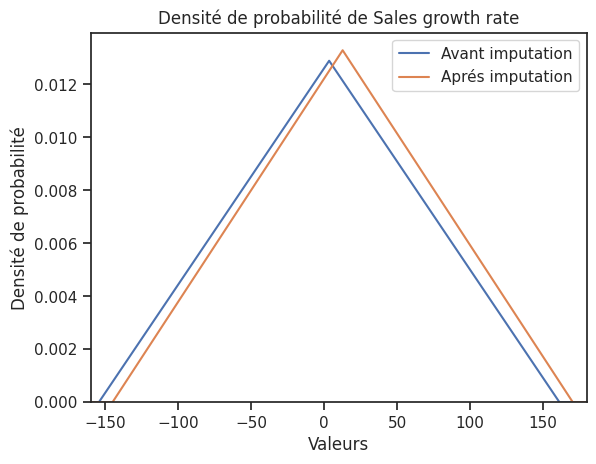

In [ ]:
variable1 = filtered_df['Sales growth rate']
variable2 = df_reconstructed['Sales growth rate']
fig, ax = plt.subplots()

sns.kdeplot(variable1, ax=ax, label='Before imputation')
sns.kdeplot(variable2, ax=ax, label='After imputation')

ax.set_xlim(-160, 180)

plt.legend()
plt.xlabel('Values')
plt.ylabel('Peobability density')
plt.title('Probability density of Sales growth rate')

plt.show()

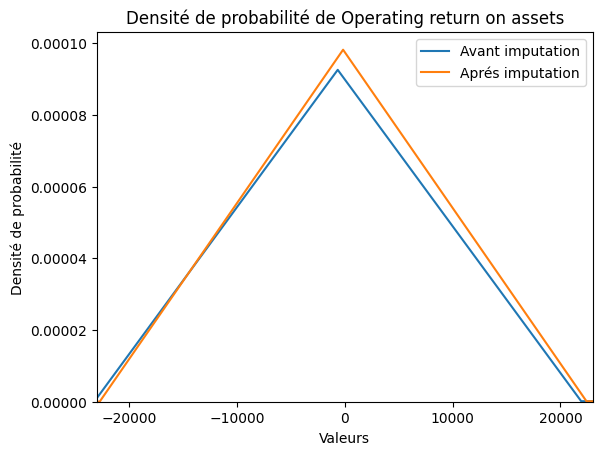

In [ ]:
variable1 = filtered_df['Operating return on assets']
variable2 = df_reconstructed['Operating return on assets']
fig, ax = plt.subplots()

sns.kdeplot(variable1, ax=ax, label='Before imputation')
sns.kdeplot(variable2, ax=ax, label='After imputation')

ax.set_xlim(-23000, 23000)

plt.legend()
plt.xlabel('Values')
plt.ylabel('Probability density')
plt.title('Probability density of Operating return on assets')

plt.show()

As mentioned earlier, the decision on the adopted imputation technique will be based on the density before and after imputation.

Here, we have two variables with a missing rate between 5% and 35% ("Operating return on assets" and "Sales growth rate"). The graphs show a similarity in density before and after imputation. Therefore, our choice (imputation by mean) is acceptable.

Note: We have presented only two graphs for two reasons:

    1- Quantity of available data (~63 variables)

    2- Other variables have a rate below 5% (where the imputation bias will be negligible)

#### b- Outliers

There are several techniques for detecting outlier values:

    * Tukey's and Chauvenet's criteria,
    * Q-Dixon, Grubbs, Tietjen-Moore, and Tau tests,
    * Extreme Studentized Deviate.

To correct these values, we can use:

    * Exclusion (conversion to missing values),
    * binning,
    * weight assignment,
    * logarithmic transformations,
    * IQR (Interquartile Range),
    * Variational Mode Decomposition,
    * SVM (Support Vector Machines),
    * ARIMA (AutoRegressive Integrated Moving Average).

=> In the current case study, we will use Tukey's criterion for detection and correction by the median.

In [ ]:
def detecter_corriger_valeurs_aberrantes(data):
  """
  This function detect outliers values

  Input:
      data (dataframe): data
  Output:
        data_corrigee (dataframe): done data

  """
  data_corrigee = data.copy()

  for column in data.columns:
      if data[column].dtype != np.object:
          q1 = data[column].quantile(0.25)
          q3 = data[column].quantile(0.75)
          iqr = q3 - q1

          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr

          data_corrigee.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = data[column].median()

  return data_corrigee

In [ ]:
valeurs_aberrantes = detecter_corriger_valeurs_aberrantes(df_reconstructed)

<ipython-input-61-be139addbc63>:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[column].dtype != np.object:  # Exclure les variables catégorielles
<ipython-input-61-be139addbc63>:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[column].dtype != np.object:  # Exclure les variables catégorielles
<ipython-input-61-be139addbc63>:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself.

*** Although missing values can introduce estimation bias, it is preferable to always check whether the missing value in question is plausible or not. ***

#### c- Multicollinearity

The "Variance Inflation Factor" (VIF) is a statistical measure used to assess multicollinearity.

In [ ]:

def calc_vif(X):
  """
  Fonction detect qnd correct VA

  Input:
      X (dataframe): data
  Output:
        vif (dataframe): data true

  """

  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return(vif)

In [ ]:
df = valeurs_aberrantes.iloc[:, 1:63]
df_vif = calc_vif(df)

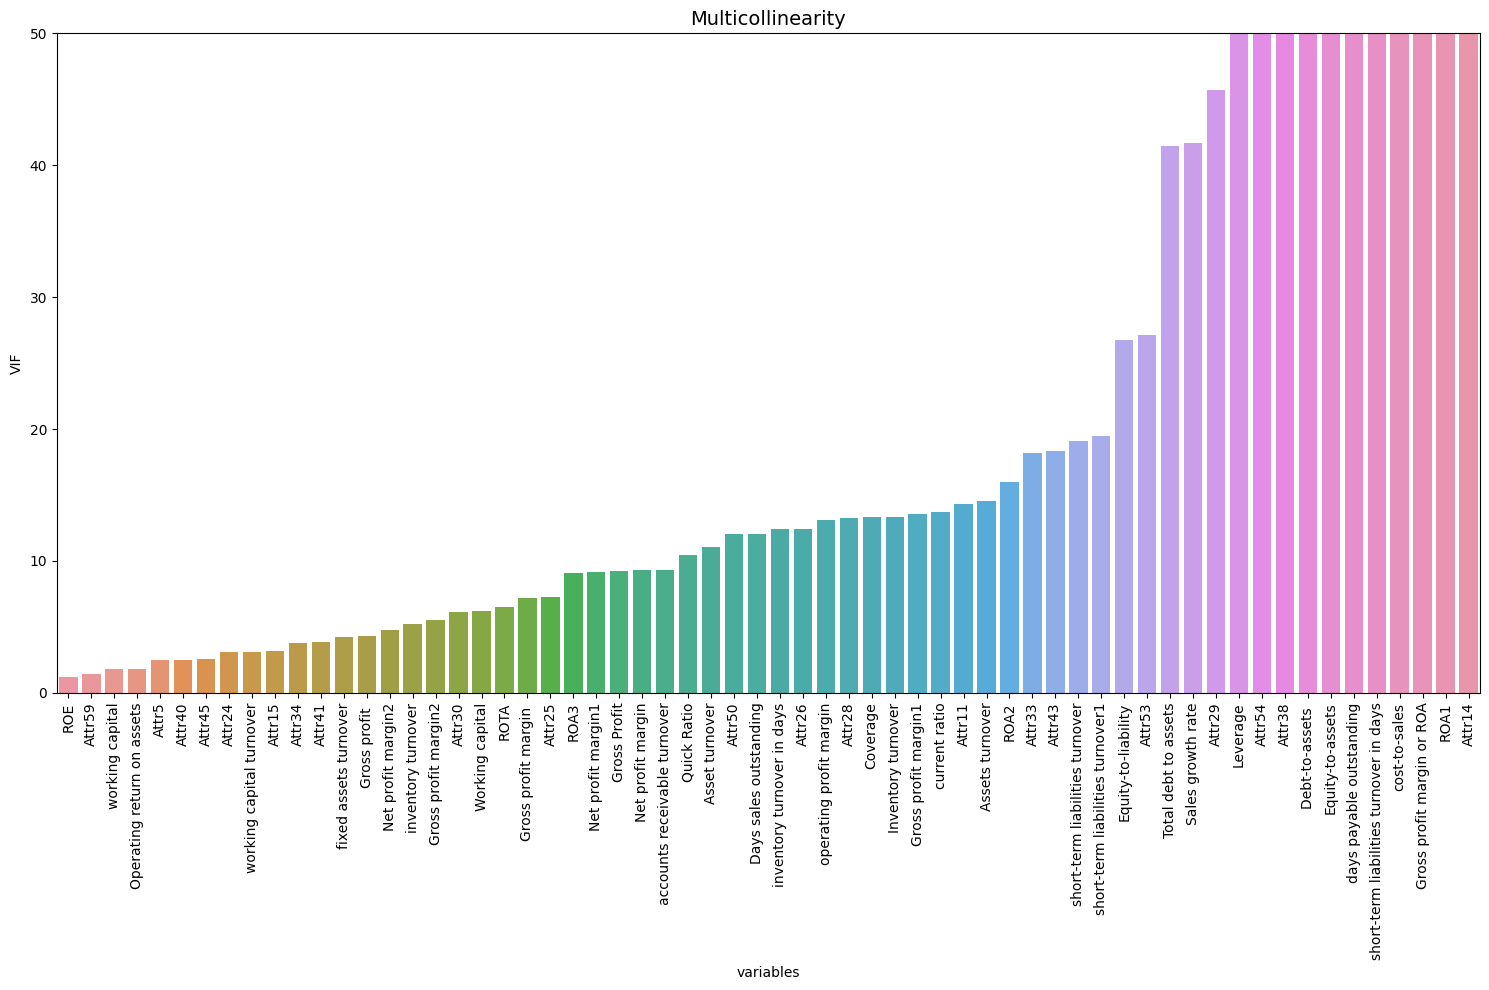

In [ ]:
plt.figure(figsize=(15,10))
# make barplot and sort bars
sns.barplot(x='variables',
            y="VIF",
            data=df_vif,
            order=df_vif.sort_values('VIF').variables)
# set labels
plt.ylim(0, 50)
plt.xlabel("variables", size=10)
plt.ylabel("VIF", size=10)
plt.title("Multicollinearity", size=14)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# Supprimer les variables qui ont un VIF > 24
variables_to_drop = df_vif[df_vif['VIF'] < 25]['variables'].values
data_vif = valeurs_aberrantes.drop(variables_to_drop, axis=1)

In [ ]:
data_vif.head()

ROA  Debt-to-assets       ROA1  Equity-to-liability  Equity-to-assets  \
0  0.200550          0.37951  0.249760              1.33050           0.50494   
1  0.209120          0.49988  0.258340              0.99601           0.49788   
2  0.248660          0.69592  0.309060              0.43695           0.30408   
3  0.081483          0.30734  0.092704              1.86610           0.57353   
4  0.187320          0.61323  0.187320              0.63070           0.38677   

     Attr14  Leverage  Gross profit margin or ROA  Sales growth rate  Attr29  \
0  0.249760    2.6349                    0.249760             1.2479  5.9443   
1  0.258340    2.0005                    0.258340             1.4293  3.6884   
2  0.309060    1.4369                    0.309060             1.4283  4.3749   
3  0.092704    3.2537                    0.092704             1.0325  4.6511   
4  0.187320    1.6307                    0.187320             1.0325  4.1424   

   days payable outstanding   Attr38  Total debt to assets  \
0                     94.14  0.50591               0.37854   
1                    122.17  0.49788               0.49988   
2                    176.93  0.51537               0.48152   
3                     91.37  0.57353               0.30734   
4                    147.04  0.43489               0.56511   

   short-term liabilities turnover in days   Attr53  Attr54  cost-to-sales  \
0                                  0.25792  2.24370  2.2480        0.87804   
1                                  0.33472  1.19455  1.3693        0.85300   
2                                  0.48474  1.20980  2.0504        0.76599   
3                                  0.25033  2.45240  2.4524        0.94598   
4                                  0.40285  1.88390  2.1184        0.86515   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

### 3.2. Feature selection

There are several algorithms for selecting relevant variables, which can be divided into three groups:

    * Wrapper: Forward selection, Backward elimination, Bi-directional elimination, Exhaustive selection, Recursive elimination
    * Filter: Information Gain, Chi-square test, Fisher’s Score, Correlation Coefficient, Variance Threshold, Mean Absolute Difference, Dispersion Ratio, Mutual Dependence, Relief, Pearson’s correlation, Spearman’s rank, ANOVA, Kendall’s rank
    * Embedded: Regularization, Tree-based methods

=> In my opinion, the ideal approach is to conduct a "vote" among these algorithms, and then adopt the variables with the highest votes

** Note: An expert's opinion can be added here, and the weights will be weighted by this choice. **


In [ ]:
# Convert the object column to integer
data_vif['target'] = data_vif['target'].astype(int)
#data_vif['target'] = data_vif['target'].astype('float64')
X = data_vif.iloc[:,1:16]
y  = data_vif.iloc[:,17]
feature_name = X.columns.tolist()

In [ ]:
# 1- Pearson Correlation
def cor_selector(X, y):
    """
    Fonction calcul la correlation entre la variable et le cible (target)
    Input:
          X (dataframe) : les variables dépendantes
          Y (dataframe/ array) : la variable cible

    """
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y)

In [ ]:
# 2- Chi-2
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=14)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [ ]:
# 3- Wrapper (RFE & RFEcv)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [ ]:
# 4- Embeded (L1)
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"))
embeded_lr_selector.fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

In [ ]:
# 5- Random Forest
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=17))
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [ ]:
# 6- LightGBM
lgbc=LGBMClassifier(n_estimators=18, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc)
embeded_lgb_selector.fit(X, y)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

In [ ]:
# 7- Summary
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
feature_selection_df

Feature  Pearson  Chi-2   RFE  Logistics  \
1                                    Attr38     True   True  True       True   
2   short-term liabilities turnover in days     True   True  True       True   
3                  days payable outstanding     True   True  True       True   
4                                  Leverage     True   True  True       True   
5                       Equity-to-liability     True   True  True       True   
6                                    Attr29     True   True  True      False   
7                      Total debt to assets     True   True  True      False   
8                                      ROA1     True   True  True      False   
9                          Equity-to-assets     True   True  True      False   
10                          Debt-to-assets      True   True  True      False   
11                                   Attr54     True   True  True       True   
12                                   Attr14     True   True  True      False   
13                        Sales growth rate     True  False  True      False   
14               Gross profit margin or ROA     True   True  True      False   
15                                   Attr53     True   True  True      False   

    Random Forest  LightGBM  Total  
1            True      True      6  
2            True     False      5  
3            True     False      5  
4            True     False      5  
5            True     False      5  
6            True      True      5  
7            True     False      4  
8           False      True      4  
9            True     False      4  
10          False      True      4  
11          False     False      4  
12          False      True      4  
13          False      True      3  
14          False     False      3  
15          False     False      3

In [ ]:
# Créer une liste à partir de la colonne désirée lorsque l'autre colonne a une valeur supérieure ou égale à 4
liste_valeurs = feature_selection_df.loc[feature_selection_df['Total'] >= 4, 'Feature'].tolist()
liste_valeurs.append('target')

In [ ]:
data_modelisation = data_vif[liste_valeurs]

In [ ]:
data_modelisation.head()

Attr38  short-term liabilities turnover in days  days payable outstanding  \
0  0.50591                                  0.25792                     94.14   
1  0.49788                                  0.33472                    122.17   
2  0.51537                                  0.48474                    176.93   
3  0.57353                                  0.25033                     91.37   
4  0.43489                                  0.40285                    147.04   

   Leverage  Equity-to-liability  Attr29  Total debt to assets      ROA1  \
0    2.6349              1.33050  5.9443               0.37854  0.249760   
1    2.0005              0.99601  3.6884               0.49988  0.258340   
2    1.4369              0.43695  4.3749               0.48152  0.309060   
3    3.2537              1.86610  4.6511               0.30734  0.092704   
4    1.6307              0.63070  4.1424               0.56511  0.187320   

   Equity-to-assets  Debt-to-assets   Attr54    Attr14  target  
0           0.50494          0.37951  2.2480  0.249760       0  
1           0.49788          0.49988  1.3693  0.258340       0  
2           0.30408          0.69592  2.0504  0.309060       0  
3           0.57353          0.30734  2.4524  0.092704       0  
4           0.38677          0.61323  2.1184  0.187320       0

In [ ]:
#feature_selection_df_woe.to_excel('C:/Users/test/Desktop/feature_selection_woe.xlsx',sheet_name='sheet1',index=False)

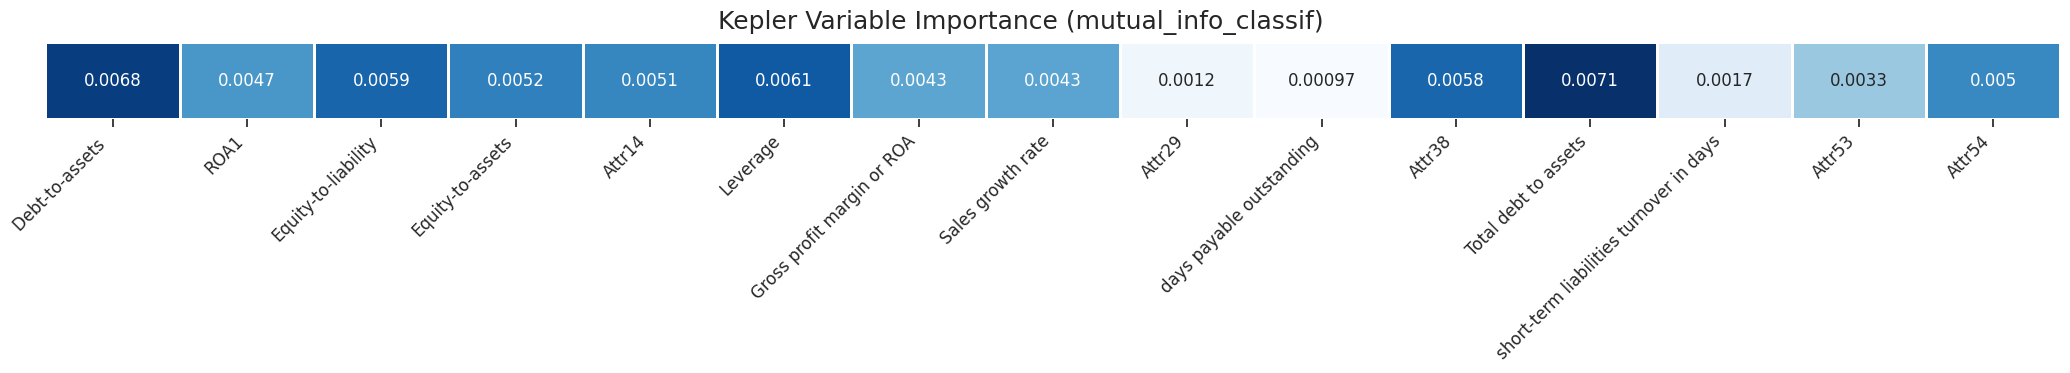

In [ ]:
# En outre, on peut utiliser l'information mutuelle de Kepler qui est une mesure
# de la dépendance mutuelle ou de l'information partagée entre deux variables aléatoires.

# Kepler Mutual Information
kepler_X = data_vif.iloc[:,1:16]
kepler_y = data_vif.iloc[:,17]

kepler_mutual_information = mutual_info_classif(kepler_X, kepler_y)
plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(kepler_X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

### 3.3. Split data

In [ ]:

train, test = train_test_split(data_modelisation, test_size=0.25, random_state = 42)
test.to_csv('test.txt', header=True, index=False, sep='\t', mode='a')
train.to_csv('train.txt', header=True, index=False, sep='\t', mode='a')
print('The train data shape is :\n',train.shape)
print('The test data shape is :\n',test.shape)

The train data shape is :
 (28121, 13)
The test data shape is :
 (9374, 13)


In [ ]:
# Importer les données
file = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt


In [ ]:
train = pd.read_csv("train.txt", delimiter='\t')
test = pd.read_csv("test.txt", delimiter='\t')

In [ ]:
X_test = test.drop('target', axis=1)
Y_test = test[['target']]
X_train = train.drop('target', axis=1)
Y_train = train[['target']]

### 3.3. Scaling

Scaling is an important step before moving on to modeling. It allows us to standardize the database, and there are several scaling techniques:

    * Normalization (standardization)
    * Min-Max
    * Weight of Evidence (WoE)

=> Since the variables in the current database are quantitative, we will use "normalization."

In [ ]:
# Compute mean and std for each variables
mean_values = X_train.mean()
std_values = X_train.std()
# Create new data frame
summary_df = pd.DataFrame({'Moyenne': mean_values, 'Écart type': std_values})
# Save data as excel
summary_df.to_excel('summary_df.xlsx', index=False)
summary_df

Moyenne  Écart type
Attr38                                    0.593411    0.230881
short-term liabilities turnover in days   0.226879    0.137081
days payable outstanding                 82.970493   50.115707
Leverage                                  2.335041    1.292264
Equity-to-liability                       1.284754    1.253599
Attr29                                    3.984451    0.755087
Total debt to assets                      0.367272    0.225261
ROA1                                      0.072702    0.104962
Equity-to-assets                          0.502198    0.264038
Debt-to-assets                            0.479888    0.265769
Attr54                                    1.449224    0.796287
Attr14                                    0.072716    0.104959

The table above will be used in the production phase. When we have data for a new company, we should perform standardization using the modeling data.

In [ ]:
test_std = (X_test-X_train.mean())/X_train.std()
train_std = (X_train-X_train.mean())/X_train.std()

## 4- Modeling

### 4.1. Sampling

In [ ]:
Y_train.head()

target
0       0
1       0
2       0
3       0
4       0

In [ ]:
# SMOTE
sm = SMOTE(random_state=42)
X_sm_std, y_sm_std = sm.fit_resample(train_std, Y_train)

### 4.2. Prediction

In [ ]:
def Logistic_Regression (X_train, X_test, y_train) :
  """
  Fonction predict RL
  Input :
        X_train (dataframe): data train
        X_test (dataframe): data test
        y_train (dataframe): target
  Output :
          y_pred (dataframe):
          mlp_fit (model):
  """

  logreg = LogisticRegression()
  lr_fit = logreg.fit(X_train,y_train)
  y_pred=logreg.predict_proba(X_test)
  return y_pred, lr_fit

def Random_Forest(X_train, X_test, y_train, n_est=100) :
  """
  Fonction predict RF
  Input :
        X_train (dataframe): data train
        X_test (dataframe): data test
        y_train (dataframe): target
        n_est (): nombre prediction default =100
  Output :
          y_pred (dataframe):
          mlp_fit (model):
  """

  clf=RandomForestClassifier(n_estimators=n_est)
  rf_fit = clf.fit(X_train,y_train)
  y_pred=clf.predict_proba(X_test)
  return y_pred, rf_fit

def XGB_Classifier (X_train,y_train,X_test):
  """
  Fonction predict XGB
  Input :
        X_train (dataframe): data train
        X_test (dataframe): data test
        y_train (dataframe): target
  Output :
          y_pred (dataframe):
          mlp_fit (model):
  """

  model = XGBClassifier()
  xgb_fit = model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)
  return y_pred, xgb_fit

def light_gbm (X_train,y_train,X_test):
  """
  Fonction predict GBM
  Input :
        X_train (dataframe): data train
        X_test (dataframe): data test
        y_train (dataframe): target
  Output :
          y_pred (dataframe):
          mlp_fit (model):
  """

  clf = lgb.LGBMClassifier()
  gbm_fit = clf.fit(X_train, y_train)
  y_pred=clf.predict_proba(X_test)
  return y_pred, gbm_fit

def neural_network_MLP (X_train,y_train, X_test):
  """
  Fonction predict MLP
  Input :
        X_train (dataframe): data train
        X_test (dataframe): data test
        y_train (dataframe): target
  Output :
          y_pred (dataframe):
          mlp_fit (model):
  """

  clf = MLPClassifier()
  mlp_fit = clf.fit(X_train,y_train)
  y_pred=clf.predict_proba(X_test)
  return y_pred, mlp_fit

In [ ]:
p_lr, m_lr = Logistic_Regression (X_sm_std, test_std, y_sm_std)
p_rf, m_rf = Random_Forest(X_sm_std, test_std, y_sm_std, n_est=100)
p_xgb, m_xgb = XGB_Classifier(X_sm_std, y_sm_std, test_std)
p_gbm, m_gbm = light_gbm(X_sm_std, y_sm_std, test_std)
p_mlp, m_mlp = neural_network_MLP(X_sm_std, y_sm_std, test_std)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-140-8097ea67ce0a>:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fit = clf.fit(X_train,y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

In [ ]:
# Save models as sav
pickle.dump(m_lr, open('m_lr.sav', 'wb'))
pickle.dump(m_rf, open('m_rf.sav', 'wb'))
pickle.dump(m_xgb, open('m_xgb.sav', 'wb'))
pickle.dump(m_gbm, open('m_gbm.sav', 'wb'))
pickle.dump(m_mlp, open('m_mlp.sav', 'wb'))

In [ ]:
# Import data
file = files.upload()

In [ ]:
# Import models
loaded_m_lr = pickle.load(open('m_lr.sav', 'rb'))
loaded_m_rf = pickle.load(open('m_rf.sav', 'rb'))
loaded_m_xgb = pickle.load(open('m_xgb.sav', 'rb'))
loaded_m_gbm = pickle.load(open('m_gbm.sav', 'rb'))
loaded_m_mlp = pickle.load(open('m_mlp.sav', 'rb'))

## 5- Evaluation

#### 5.1. ROC curve

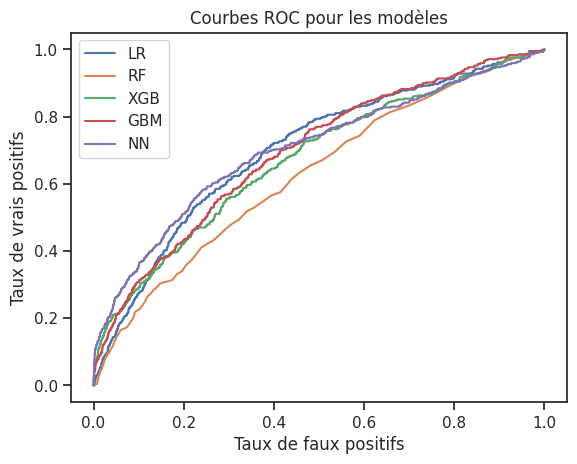

In [ ]:

models = [
    ("LR", m_lr),
    ("RF", m_rf),
    ("XGB", m_xgb),
    ("GBM", m_gbm),
    ("NN", m_mlp)
]


plt.figure()

for name, pipeline in models:

    y_pred_proba = pipeline.predict_proba(test_std)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)

    plt.plot(fpr, tpr, label=name)

plt.xlabel('False positif')
plt.ylabel('True positif')
plt.title('ROC curve')
plt.legend()

plt.show()

### 5.2. Score

#### a. ODDS

The term "ODDS" or "odds ratio" is frequently used in the field of financial risk to represent the relationship between the chances of success and the chances of failure.

In [ ]:
def odds (p) :
  """
  Odds ratio of being healthy to bankruptcy

  Input :
        p (array): bankruptcy probqbility
  Output:
        odds (array): odds

  """

  odd= (1-p)/p
  return odd


In [ ]:
odd_lr = odds(p_lr[:,1])
odd_rf = odds(p_rf[:,1])
odd_xgb = odds(p_xgb[:,1])
odd_gbm = odds(p_gbm[:,1])
odd_mlp = odds(p_mlp[:,1])

<ipython-input-144-67ac23dd468f>:12: RuntimeWarning: divide by zero encountered in true_divide
  odd= (1-p)/p


#### b- Score std Dataframe

The objective of the code below is to harmonize the odds ratio results from all algorithms.

In [ ]:
score_lr = (odd_lr-odd_lr.min())/(odd_lr.max()-odd_lr.min())*100
score_rf = (odd_rf-odd_rf.min())/(odd_rf.max()-odd_rf.min())*100
score_xgb = (odd_xgb-odd_xgb.min())/(odd_xgb.max()-odd_xgb.min())*100
score_gbm = (odd_gbm-odd_gbm.min())/(odd_gbm.max()-odd_gbm.min())*100
score_mlp = (odd_mlp-odd_mlp.min())/(odd_mlp.max()-odd_mlp.min())*100

<ipython-input-146-f9ffc10b2ae1>:2: RuntimeWarning: invalid value encountered in true_divide
  score_rf = (odd_rf-odd_rf.min())/(odd_rf.max()-odd_rf.min())*100


In [ ]:
# Dataframe results
data_pred = pd.DataFrame(np.column_stack((p_lr[:,1],  p_rf[:,1], p_xgb[:,1], p_gbm[:,1],
                              p_mlp[:,1], odd_lr, odd_rf, odd_xgb, odd_gbm,
                              odd_mlp, score_lr, score_rf, score_xgb, score_gbm,
                              score_mlp, Y_test)),
             columns=['p_lr' , 'p_rf' , 'p_xgb' , 'p_gbm' , 'p_mlp' , 'odd_lr',
                      'odd_rf', 'odd_xgb', 'odd_gbm', 'odd_mlp', 'score_lr',
                      'score_rf', 'score_xgb', 'score_gbm', 'score_mlp', 'Y_test'])

data_pred.head()

p_lr  p_rf     p_xgb     p_gbm     p_mlp    odd_lr     odd_rf  \
0  0.611645  0.50  0.516243  0.693551  0.238043  0.634934   1.000000   
1  0.380289  0.02  0.015825  0.015980  0.004488  1.629576  49.000000   
2  0.575891  0.13  0.079687  0.180581  0.739094  0.736440   6.692308   
3  0.391139  0.10  0.429009  0.385931  0.192364  1.556633   9.000000   
4  0.401559  0.17  0.435375  0.270748  0.507607  1.490291   4.882353   

     odd_xgb    odd_gbm     odd_mlp  score_lr  score_rf  score_xgb  score_gbm  \
0   0.937073   0.441855    3.200913  2.223541       0.0   0.001647   0.079163   
1  62.189434  61.578732  221.838145  5.873688       0.0   0.110650  11.959436   
2  11.549058   4.537696    0.353009  2.596048       0.0   0.020532   0.875077   
3   1.330952   1.591135    4.198486  5.606001       0.0   0.002348   0.302494   
4   1.296873   2.693467    0.970029  5.362538       0.0   0.002288   0.516702   

      score_mlp  Y_test  
0  3.253429e-06     0.0  
1  2.254777e-04     0.0  
2  3.588001e-07     0.0  
3  4.267368e-06     0.0  
4  9.859435e-07     0.0

In [ ]:
data_pred['rating']=pd.cut(data_pred['p_mlp'],8,labels=['D','C','B','BB','BBB', 'A', 'AA', 'AAA'])
data_pred.head()

p_lr  p_rf     p_xgb     p_gbm     p_mlp    odd_lr     odd_rf  \
0  0.611645  0.50  0.516243  0.693551  0.238043  0.634934   1.000000   
1  0.380289  0.02  0.015825  0.015980  0.004488  1.629576  49.000000   
2  0.575891  0.13  0.079687  0.180581  0.739094  0.736440   6.692308   
3  0.391139  0.10  0.429009  0.385931  0.192364  1.556633   9.000000   
4  0.401559  0.17  0.435375  0.270748  0.507607  1.490291   4.882353   

     odd_xgb    odd_gbm     odd_mlp  score_lr  score_rf  score_xgb  score_gbm  \
0   0.937073   0.441855    3.200913  2.223541       0.0   0.001647   0.079163   
1  62.189434  61.578732  221.838145  5.873688       0.0   0.110650  11.959436   
2  11.549058   4.537696    0.353009  2.596048       0.0   0.020532   0.875077   
3   1.330952   1.591135    4.198486  5.606001       0.0   0.002348   0.302494   
4   1.296873   2.693467    0.970029  5.362538       0.0   0.002288   0.516702   

      score_mlp  Y_test rating  
0  3.253429e-06     0.0      C  
1  2.254777e-04     0.0      D  
2  3.588001e-07     0.0      A  
3  4.267368e-06     0.0      C  
4  9.859435e-07     0.0    BBB

#### c- Score Distribution

##### RL

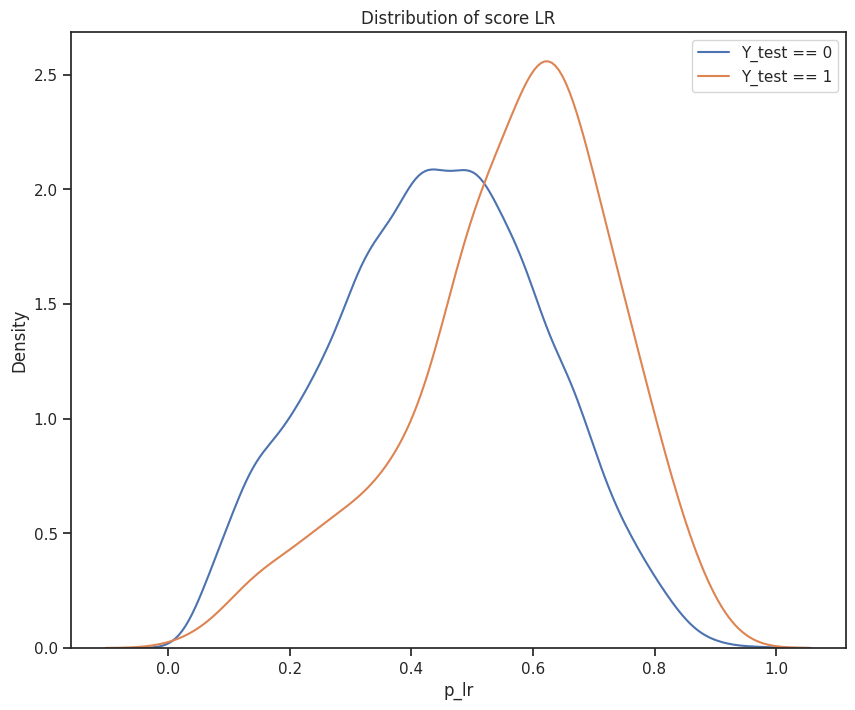

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 0, 'p_lr'], label = 'Y_test == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 1, 'p_lr'] , label = 'Y_test == 1')

# Labeling of plot
plt.xlabel('p_lr'); plt.ylabel('Density'); plt.title('Distribution of score LR');plt.legend();
#plt.xlim([0, 100]);

##### RF

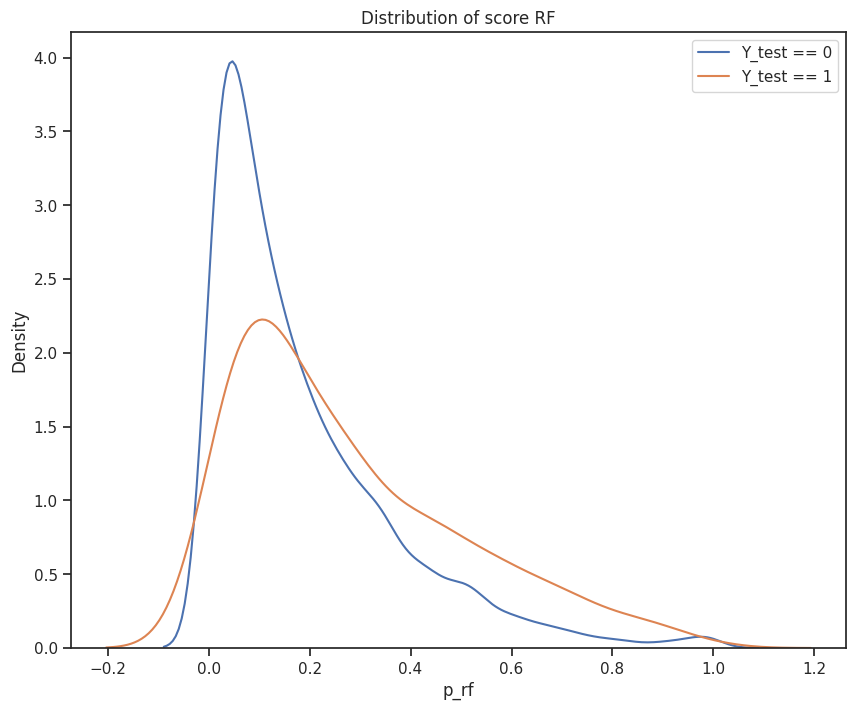

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 0, 'p_rf'], label = 'Y_test == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 1, 'p_rf'] , label = 'Y_test == 1')

# Labeling of plot
plt.xlabel('p_rf'); plt.ylabel('Density'); plt.title('Distribution of score RF');plt.legend();
#plt.xlim([0, 100]);

##### XGB

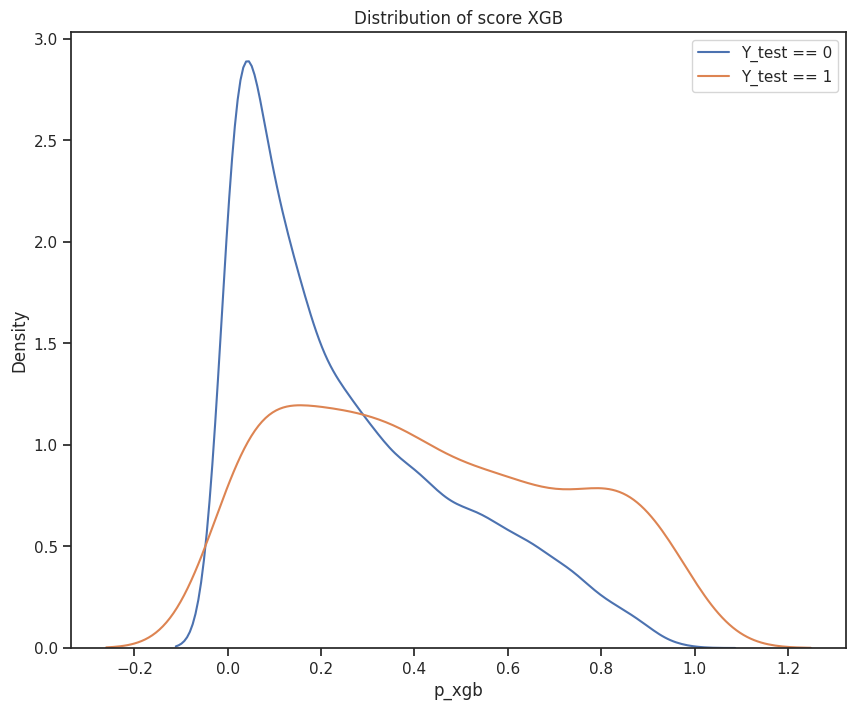

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 0, 'p_xgb'], label = 'Y_test == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 1, 'p_xgb'] , label = 'Y_test == 1')

# Labeling of plot
plt.xlabel('p_xgb'); plt.ylabel('Density'); plt.title('Distribution of score XGB');plt.legend();
#plt.xlim([0, 100]);

##### GBM

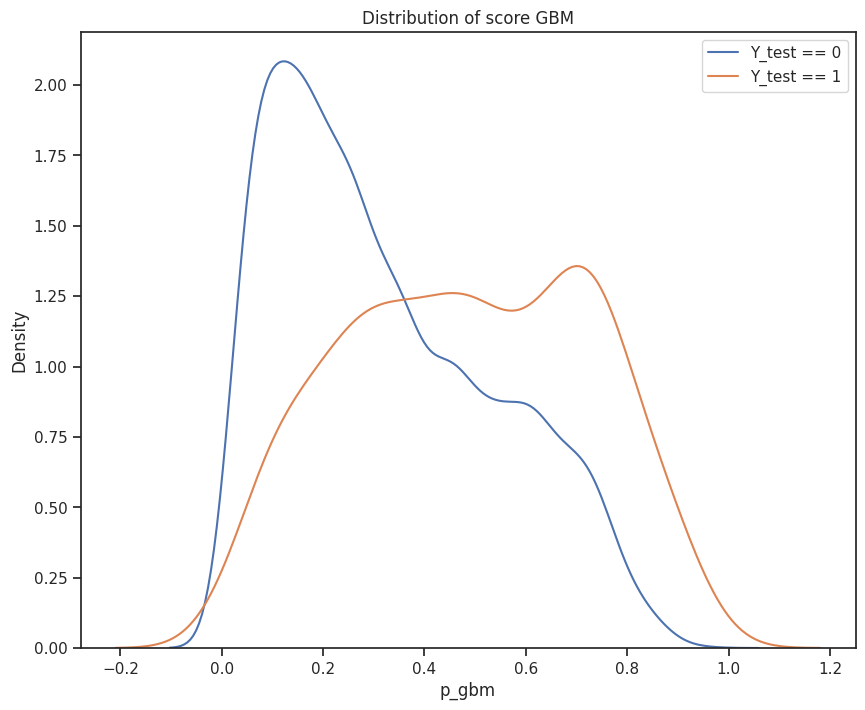

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 0, 'p_gbm'], label = 'Y_test == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 1, 'p_gbm'] , label = 'Y_test == 1')

# Labeling of plot
plt.xlabel('p_gbm'); plt.ylabel('Density'); plt.title('Distribution of score GBM');plt.legend();
#plt.xlim([0, 100]);

##### MLP

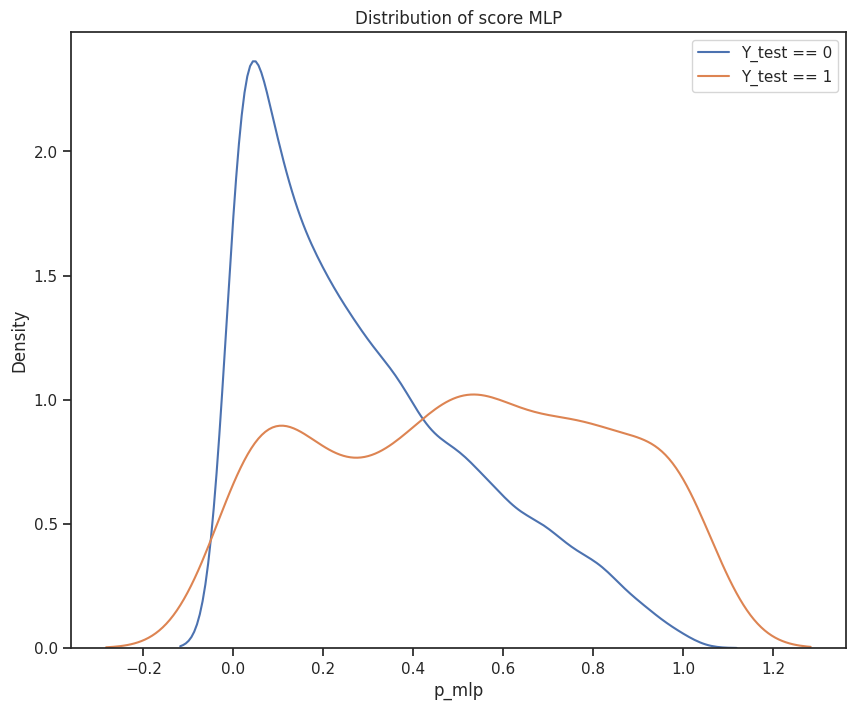

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 0, 'p_mlp'], label = 'Y_test == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data_pred.loc[data_pred['Y_test'] == 1, 'p_mlp'] , label = 'Y_test == 1')

# Labeling of plot
plt.xlabel('p_mlp'); plt.ylabel('Density'); plt.title('Distribution of score MLP');plt.legend();
#plt.xlim([0, 100]);

La distribution de la probabilité de "faillite" et celle de non-faillite nous permet de donner une idée sur le degré de discrimination du modèle, où moins qu'on a un chevauchement entre le deux densités on aura un degré de discrimination fort.

Le modèle "Régression logistique est plus discriminante, c'est évidant de trouver ce résultat puisqu'on fait de la modèlisation des variables issues du "bilan comptable" dont on a plusieurs identités comptables (les identités comptables sont des équations ou des relations qui doivent être respectées dans le domaine de la comptabilité).

##### Rqting Disribution

<Axes: xlabel='rating', ylabel='p_mlp'>

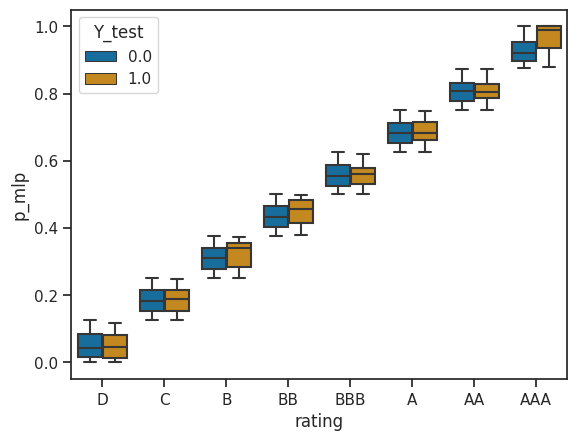

In [ ]:
sns.boxplot(y='p_mlp', x='rating',
                 data=data_pred,
                 palette="colorblind",
                 hue='Y_test')

#### d- Boxplot score

##### LR

<Axes: xlabel='Y_test', ylabel='odd_lr'>

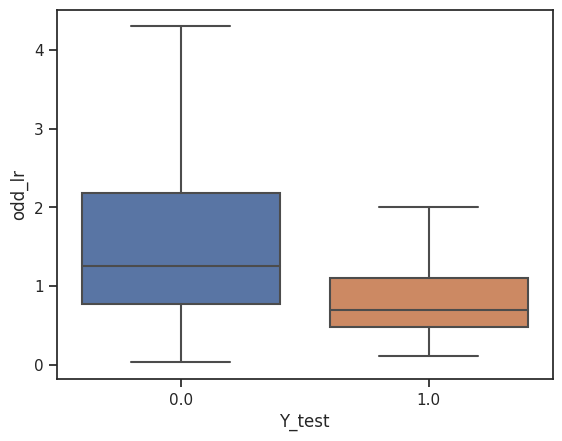

In [ ]:
sns.boxplot(x='Y_test', y='odd_lr', data=data_pred, showfliers=False)

##### RF

<Axes: xlabel='Y_test', ylabel='odd_rf'>

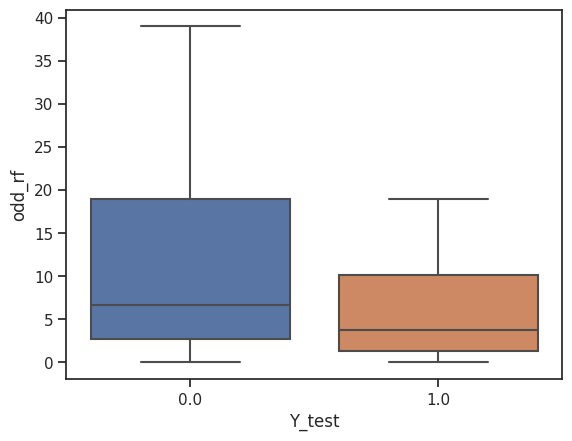

In [ ]:
sns.boxplot(x='Y_test', y='odd_rf', data=data_pred, showfliers=False)

##### XGB

<Axes: xlabel='Y_test', ylabel='odd_xgb'>

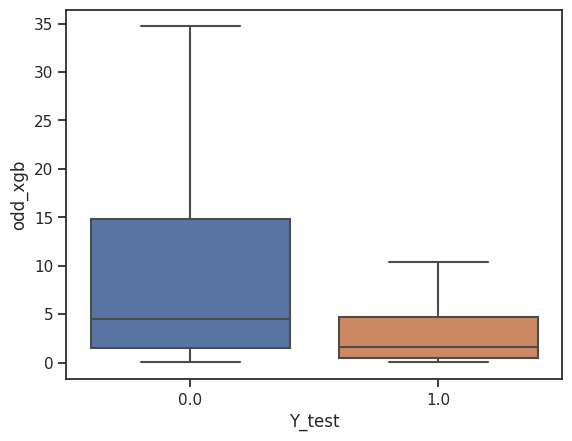

In [ ]:
sns.boxplot(x='Y_test', y='odd_xgb', data=data_pred, showfliers=False)

##### GBM

<Axes: xlabel='Y_test', ylabel='odd_gbm'>

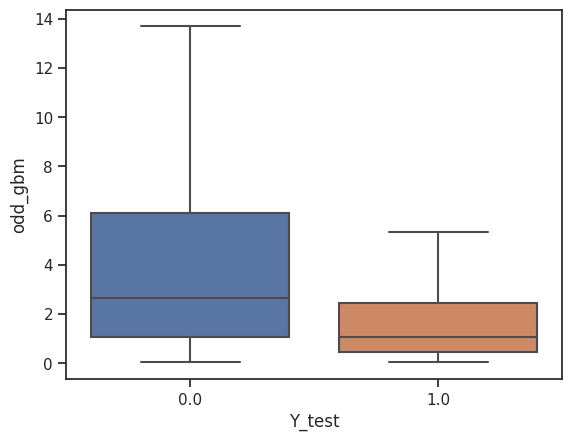

In [ ]:
sns.boxplot(x='Y_test', y='odd_gbm', data=data_pred, showfliers=False)

##### MLP

<Axes: xlabel='Y_test', ylabel='odd_mlp'>

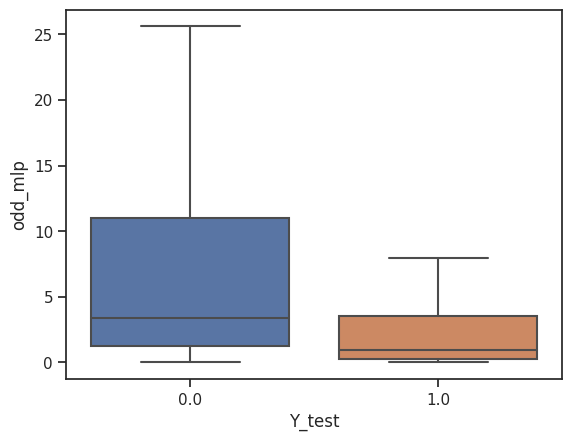

In [ ]:
sns.boxplot(x='Y_test', y='odd_mlp', data=data_pred, showfliers=False)

By analyzing the box plots of odds ratios (ODDS), we observe that the interquartile range (IQR), which represents 50% of the observations, for bankrupt companies is consistently below the median of the IQRs for healthy companies. This result leads us to conclude that a new sampling (individuals or variables) or optimization at the algorithm level may lead to improved estimates.